<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Naming-conventions" data-toc-modified-id="Naming-conventions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Naming conventions</a></span></li><li><span><a href="#Config" data-toc-modified-id="Config-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Config</a></span></li><li><span><a href="#Load-Standards" data-toc-modified-id="Load-Standards-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load Standards</a></span></li><li><span><a href="#Load-datas" data-toc-modified-id="Load-datas-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load datas</a></span><ul class="toc-item"><li><span><a href="#Helper-Functions" data-toc-modified-id="Helper-Functions-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Helper Functions</a></span></li><li><span><a href="#Animal-emissions" data-toc-modified-id="Animal-emissions-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Animal emissions</a></span><ul class="toc-item"><li><span><a href="#Tables-description" data-toc-modified-id="Tables-description-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>Tables description</a></span></li><li><span><a href="#Enteric-Fermentation" data-toc-modified-id="Enteric-Fermentation-4.2.2"><span class="toc-item-num">4.2.2&nbsp;&nbsp;</span>Enteric Fermentation</a></span><ul class="toc-item"><li><span><a href="#Element-Column" data-toc-modified-id="Element-Column-4.2.2.1"><span class="toc-item-num">4.2.2.1&nbsp;&nbsp;</span>Element Column</a></span></li><li><span><a href="#Item-Column" data-toc-modified-id="Item-Column-4.2.2.2"><span class="toc-item-num">4.2.2.2&nbsp;&nbsp;</span>Item Column</a></span></li></ul></li><li><span><a href="#Manure-Soils" data-toc-modified-id="Manure-Soils-4.2.3"><span class="toc-item-num">4.2.3&nbsp;&nbsp;</span>Manure Soils</a></span><ul class="toc-item"><li><span><a href="#Checking-for-null-values" data-toc-modified-id="Checking-for-null-values-4.2.3.1"><span class="toc-item-num">4.2.3.1&nbsp;&nbsp;</span>Checking for null values</a></span></li><li><span><a href="#Element-column" data-toc-modified-id="Element-column-4.2.3.2"><span class="toc-item-num">4.2.3.2&nbsp;&nbsp;</span>Element column</a></span></li><li><span><a href="#Item-column" data-toc-modified-id="Item-column-4.2.3.3"><span class="toc-item-num">4.2.3.3&nbsp;&nbsp;</span>Item column</a></span></li></ul></li><li><span><a href="#Manure-Pasture" data-toc-modified-id="Manure-Pasture-4.2.4"><span class="toc-item-num">4.2.4&nbsp;&nbsp;</span>Manure Pasture</a></span><ul class="toc-item"><li><span><a href="#Checking-for-null-values" data-toc-modified-id="Checking-for-null-values-4.2.4.1"><span class="toc-item-num">4.2.4.1&nbsp;&nbsp;</span>Checking for null values</a></span></li><li><span><a href="#Element-column" data-toc-modified-id="Element-column-4.2.4.2"><span class="toc-item-num">4.2.4.2&nbsp;&nbsp;</span>Element column</a></span></li><li><span><a href="#Item-column" data-toc-modified-id="Item-column-4.2.4.3"><span class="toc-item-num">4.2.4.3&nbsp;&nbsp;</span>Item column</a></span></li></ul></li><li><span><a href="#Manure-Management" data-toc-modified-id="Manure-Management-4.2.5"><span class="toc-item-num">4.2.5&nbsp;&nbsp;</span>Manure Management</a></span><ul class="toc-item"><li><span><a href="#Checking-for-null-values" data-toc-modified-id="Checking-for-null-values-4.2.5.1"><span class="toc-item-num">4.2.5.1&nbsp;&nbsp;</span>Checking for null values</a></span></li><li><span><a href="#Element-Column" data-toc-modified-id="Element-Column-4.2.5.2"><span class="toc-item-num">4.2.5.2&nbsp;&nbsp;</span>Element Column</a></span></li><li><span><a href="#Item-column" data-toc-modified-id="Item-column-4.2.5.3"><span class="toc-item-num">4.2.5.3&nbsp;&nbsp;</span>Item column</a></span></li></ul></li></ul></li><li><span><a href="#Computed-emissions-data" data-toc-modified-id="Computed-emissions-data-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Computed emissions data</a></span></li><li><span><a href="#Productions" data-toc-modified-id="Productions-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Productions</a></span></li><li><span><a href="#Trade-data" data-toc-modified-id="Trade-data-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Trade data</a></span></li></ul></li><li><span><a href="#Products-Filtering" data-toc-modified-id="Products-Filtering-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Products Filtering</a></span></li><li><span><a href="#Livestock-food-estimate" data-toc-modified-id="Livestock-food-estimate-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Livestock food estimate</a></span><ul class="toc-item"><li><span><a href="#Beef" data-toc-modified-id="Beef-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Beef</a></span></li><li><span><a href="#Dairy-cattle" data-toc-modified-id="Dairy-cattle-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Dairy cattle</a></span></li><li><span><a href="#Swine" data-toc-modified-id="Swine-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Swine</a></span></li><li><span><a href="#Poultry" data-toc-modified-id="Poultry-6.4"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>Poultry</a></span></li><li><span><a href="#Poultry-(laying-hen)" data-toc-modified-id="Poultry-(laying-hen)-6.5"><span class="toc-item-num">6.5&nbsp;&nbsp;</span>Poultry (laying hen)</a></span></li></ul></li><li><span><a href="#Milestone-3-work" data-toc-modified-id="Milestone-3-work-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Milestone 3 work</a></span><ul class="toc-item"><li><span><a href="#Meat-Consumption" data-toc-modified-id="Meat-Consumption-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Meat Consumption</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Import-Export-Products" data-toc-modified-id="Import-Export-Products-7.1.0.1"><span class="toc-item-num">7.1.0.1&nbsp;&nbsp;</span>Import Export Products</a></span></li><li><span><a href="#Production-Meat" data-toc-modified-id="Production-Meat-7.1.0.2"><span class="toc-item-num">7.1.0.2&nbsp;&nbsp;</span>Production Meat</a></span></li><li><span><a href="#Production-Egg-or-Milk" data-toc-modified-id="Production-Egg-or-Milk-7.1.0.3"><span class="toc-item-num">7.1.0.3&nbsp;&nbsp;</span>Production Egg or Milk</a></span></li><li><span><a href="#Final-result" data-toc-modified-id="Final-result-7.1.0.4"><span class="toc-item-num">7.1.0.4&nbsp;&nbsp;</span>Final result</a></span></li></ul></li></ul></li><li><span><a href="#Animal-Productivity" data-toc-modified-id="Animal-Productivity-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Animal Productivity</a></span></li><li><span><a href="#Manure-+-Enteric-fermentation-Impact" data-toc-modified-id="Manure-+-Enteric-fermentation-Impact-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Manure + Enteric fermentation Impact</a></span></li><li><span><a href="#Animal-Feeding-Impact" data-toc-modified-id="Animal-Feeding-Impact-7.4"><span class="toc-item-num">7.4&nbsp;&nbsp;</span>Animal Feeding Impact</a></span></li></ul></li></ul></div>

In [164]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from dotmap import DotMap
from pathlib import Path
from collections.abc import Mapping, Iterable

from IPython.display import display

%matplotlib notebook
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Naming conventions

For easier reading, the following naming conventions are used. The templates are written as shell file template

+ `df_*` denotes an pandas.DataFrame
+ `dfs_*` denotes any dict-like mapping from names to pandas.DataFrame

Those naming conventions also holds for helper function signatures

# Config

In [165]:
DATA = Path("./data")

# Load Standards

Flags provide additional info on how the values in datasets where obtained

In [166]:
df_flags = pd.read_csv(
    DATA / "definitions_and_standards/flags.csv",
    keep_default_na=False,
    index_col="Flag"
)

The same country code are used in all of FAOSTAT datasets. As datasets contains aggregated data on country groups, loading that dataframe will allow to remove aggregated data.

In [167]:
df_area_groups = pd.read_csv(
    DATA / "definitions_and_standards/country_group.csv"
)

# Load datas

## Helper Functions

In [168]:
# Helper function

#snake case conversion
_first_cap_re = re.compile("(\w)([A-Z][a-z]+)")
_all_cap_re = re.compile("([a-z0-9])([A-Z])")
_space_between = re.compile("(\W*) ([a-z]*)")


def to_snakecase(name):
    s1 = _first_cap_re.sub(r"\1_\2", name)
    s2 = _all_cap_re.sub(r"\1_\2", s1).lower()
    s3 = _space_between.sub(r"\1_\2", s2)
    return s3.replace(" ", "").replace("__", "_")

def join_flags(df, filepath, df_flags):
    df["Flag"] = pd.read_csv(filepath, encoding="latin1", usecols=["Flag"], keep_default_na=False)
    return df.merge(df_flags, on="Flag").drop(columns="Flag").rename(columns={"Flags": "Flag"})

def load_df(filepath, join_df_flags=None, encoding="latin1"):
    """
    Function for quick loading of dataframes. Use the correct encoding and reloads the Flags column
    if th dataframe of the flags is provided
    """
    df = pd.read_csv(filepath, encoding=encoding)
    if join_df_flags is not None:
        df = join_flags(df, filepath, join_df_flags)
    return df

def split_on(df, column, rename={}, only_named=False, drop=[]):
    """
    Splits a dataframe in multiple dataframe based on the value of a columne
    
    Args:
        df: dataframe to spli
        column: name of the column to split on
        rename (optional): mapping or callable that rename values to name in the final dictionary
        only_named (False): keep only dataframe with a value in column that is renamed
        drop: drop columns in resulting dataframes (useful for redundant columns)
    
    Returns:
        A dictionnary mapping unique values in df[column] to the dataframe with that value.
        Value (i.e. dict keys) can be renamed by the rename argument. A callable can return None to not rename it.
    """
    result = DotMap(_dynamic=False)
    if not isinstance(drop, Iterable) or isinstance(drop, str):
        drop = [drop]
    for value in df[column].unique():
        if callable(rename):
            name = rename(value)
        elif isinstance(rename, Mapping):
            name = rename.get(value)
        else:
            name = None
        if name is None and only_named:
            continue
        result[name or value] = df[ df[column] == value].drop(columns=drop + [column])
    return result

def select_on(df, column_filter_dict):
    """
    Filter some columns of the DataFrame for values in the provided list. Equivalent to as sequence
    of isin() calls
    
    Args:
        df: the dataframe to filter
        column_value_filter_dict: a mapping from column names to the list of value to keep
    
    Returns:
        The filtered dataframe
    """
    for column, values in column_filter_dict.items():
        df = df[ df[column].isin(values) ]
    return df


def remove_country_group(df, df_area_code=None):
    """
    Remove all entries in the DataFrame for group of countries (e.g. Asia)

    Args:
        df: the DataFrame to filter
        df_area_code: dataframe from the standards, indicating which countries are in which country group
            If not provided, defaults to removing Area Code >= 5000 (see note)
    
    Returns:
        A filtered DataFrame
    
    Note:
        It appears all country-group use "Area Code" >= 5000.
        However, this is not guaranteed so we prefere to use the standars to get country group code
    """
    if df_area_code is not None:
        return df[~df["Area Code"].isin(df_area_code["Country Group Code"])]
    else:
        return df[ df["Area Code"] < 5000]

def plot_completeness_histogram(df_or_dfs, ax=None, figsize=None, agg_on="Area Code"):
    """
    Plot the histogram of how many unique area_code provide data for each year. Used
    to get an idea on how complete the data are


    Args:
        df_or_dfs: the dataframe to plot the completeness histogram of
            OR a mapping from names to dataframes
        ax: matplotlib Axis to draw on
    Returns:
        None. Plot the afformention histogram
    """
    if ax is None:
        _, ax = plt.subplots(figsize=figsize)
    if isinstance(df_or_dfs, Mapping):
        pd.DataFrame(
            {
                name: df.groupby("Year")[agg_on].nunique()
                for name, df in df_or_dfs.items()
            }
        ).plot.bar(ax=ax)
        ax.legend()
    else:
        df_or_dfs.groupby("Year")[agg_on].nunique().plot.bar(ax=ax)
    ax.set_xlabel("Year")
    ax.set_ylabel("# of countries with available data")
    ax.set_title("Evolution of data completeness")
    return ax

## Animal emissions

Load necessary dataframes and join with the flags dataframe. The "Year Code" column is redundant with the "Year" column, so we drop it

In [169]:
df_enteric_fermentation = load_df(
    DATA / "global-food-agriculture-statistics/raw_files/Emissions_Agriculture_Enteric_Fermentation_E_All_Data_(Norm).csv",
    df_flags
).drop(columns="Year Code")

df_manure_soils = load_df(
    DATA / "global-food-agriculture-statistics/raw_files/Emissions_Agriculture_Manure_applied_to_soils_E_All_Data_(Norm).csv",
    df_flags
).drop(columns="Year Code")

df_manure_management = load_df(
    DATA / "global-food-agriculture-statistics/raw_files/Emissions_Agriculture_Manure_Management_E_All_Data_(Norm).csv",
    df_flags
).drop(columns="Year Code")

df_manure_pasture = load_df(
    DATA / "global-food-agriculture-statistics/raw_files/Emissions_Agriculture_Manure_left_on_pasture_E_All_Data_(Norm).csv",
    df_flags
).drop(columns="Year Code")

### Tables description

Each of the 4 tables have the same columns, which are described below:

In [170]:
df_enteric_fermentation.columns

Index(['Country Code', 'Country', 'Item Code', 'Item', 'Element Code',
       'Element', 'Year', 'Unit', 'Value', 'Flag'],
      dtype='object')


- **Country code**: unique identifier of countries
- **Country**
- **Item**: Animal
- **Item Code**: unique identifier of Animal
- **Element**: type of GHG(Greenhouse gaz) emission / Stock
- **Element Code**: unique identifier of the type of emission
- **Year**
- **Unit**: Unit of Element
- **Value**: Value of Element
- **Flag**: Origin of the data
 


For each of these 4 tables we will start by cleaning and preprocessing the data, then do a quick analysis of the livestock species(asses, buffaloes, camels...) to see the animals that produce the most emissions in the world first by the total number of livestock species then only by head. 

### Enteric Fermentation
The table ‘Enteric Fermentation’ contains the following data:
country-level GHG(Greenhouse gaz) emissions in both Gg CH4 and Gg CO2eq, by animal categories and their aggregates, as well as their total; implied emission factors; and activity data.

In [171]:
df_enteric_fermentation.head()

,Country Code,Country,Item Code,Item,Element Code,Element,Year,Unit,Value,Flag
0,2,Afghanistan,1107,Asses,5111,Stocks,1961,Head,1300000.0,Official data
1,2,Afghanistan,1107,Asses,5111,Stocks,1962,Head,851850.0,Official data
2,2,Afghanistan,1107,Asses,5111,Stocks,1963,Head,1001112.0,Official data
3,2,Afghanistan,1107,Asses,5111,Stocks,1965,Head,1300000.0,Official data
4,2,Afghanistan,1107,Asses,5111,Stocks,1966,Head,1200000.0,Official data


In [172]:
df_enteric_fermentation.isna().any()

Country Code    False
Country         False
Item Code       False
Item            False
Element Code    False
Element         False
Year            False
Unit            False
Value           False
Flag            False
dtype: bool

No null values in this table

In [173]:
print("Unique years :\n",df_enteric_fermentation["Year"].unique())
print()
print("Unique flags :\n",df_enteric_fermentation["Flag"].unique())

Unique years :
 [1961 1962 1963 1965 1966 1967 1968 1969 1970 1971 1972 1977 1987 1999
 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 1978 1979 1980 1981 1982 1986 1973 1974 1975 1976 1995 1998 1991
 1997 1988 1989 1990 1964 1992 1993 1994 1996 1985 1983 1984 2030 2050]

Unique flags :
 ['Official data' 'FAO estimate' 'Unofficial figure' 'Calculated data'
 'Aggregate, may include official, semi-official, estimated or calculated data'
 'FAO data based on imputation methodology']


In [174]:
#Removing predictions of future years
df_enteric_fermentation = df_enteric_fermentation[df_enteric_fermentation["Year"] < 2030]

#Description of Element column
df_enteric_fermentation["Element"].unique()

array(['Stocks', 'Implied emission factor for CH4 (Enteric)',
       'Emissions (CH4) (Enteric)', 'Emissions (CO2eq) (Enteric)'],
      dtype=object)

In the *Element* column we will only be interested in the value of *Stocks* which corresponds to the total number of livestock species(asses, buffaloes, camels...) and the value of *Emissions (CO2eq) (Enteric)* which corresponds to the total aggregate of the GHG emission in CO2eq

#### Element Column 

In [175]:
#Filter the Element Column
dfs_enteric_fermentation = split_on(
    df_enteric_fermentation[
        df_enteric_fermentation["Element"].isin(["Stocks","Emissions (CO2eq) (Enteric)"])
    ],
    column="Element",
    rename={
        "Stocks": "stocks",
        "Emissions (CO2eq) (Enteric)": "emissions"
    }
)

print("Stock unit :", dfs_enteric_fermentation.stocks["Unit"].unique())
print("Emission unit :", dfs_enteric_fermentation.emissions["Unit"].unique())

Stock unit : ['Head']
Emission unit : ['Gigagrams']


#### Item Column

We keep only data aggregated on the whole world.

In [176]:
print(df_enteric_fermentation["Item"].unique())

Animals = df_enteric_fermentation["Item"].unique()

column_filters = {
    "Country" : ["World"],
    "Item" : Animals
}

dfs_enteric_fermentation_filtered = DotMap(_dynamic=False)
dfs_enteric_fermentation_filtered["stocks"] = select_on(
    dfs_enteric_fermentation.stocks,
    column_filter_dict=column_filters
)

dfs_enteric_fermentation_filtered["emissions"] = select_on(
    dfs_enteric_fermentation.emissions,
    column_filter_dict=column_filters
)

['Asses' 'Camels' 'Goats' 'Horses' 'Mules' 'Sheep' 'Buffaloes'
 'Cattle, dairy' 'Cattle, non-dairy' 'Swine, breeding' 'Swine, market'
 'Llamas' 'All Animals' 'Camels and Llamas' 'Cattle' 'Mules and Asses'
 'Sheep and Goats' 'Swine']


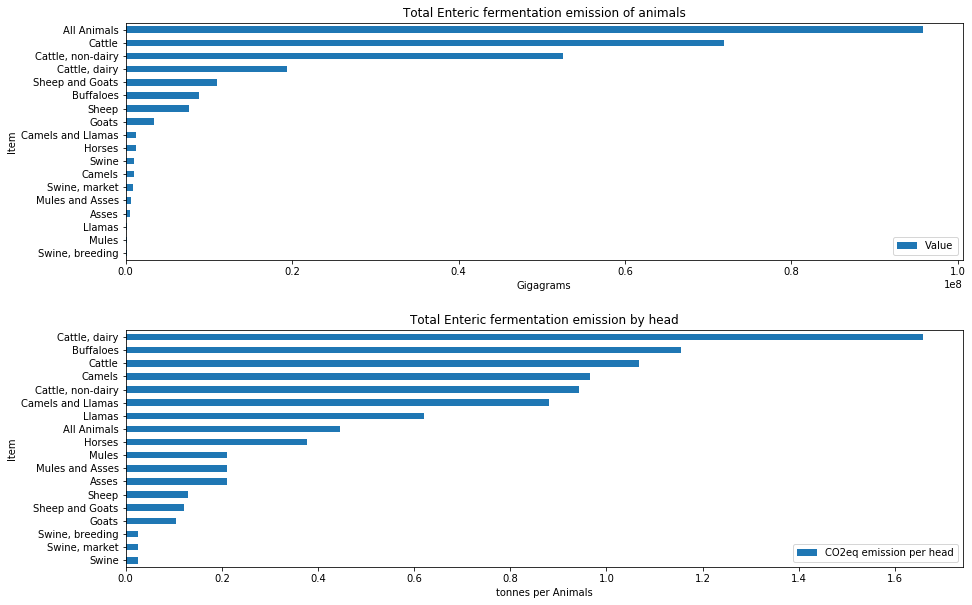

In [177]:
#Grouping stocks count
df_enteric_fermentation_stock_grouped = (
    dfs_enteric_fermentation_filtered["stocks"]
    .groupby("Item")
    ["Value"]
    .sum()
    .reset_index()
)

#Grouping total emissions count
df_enteric_fermentation_emission_grouped = (
    dfs_enteric_fermentation_filtered["emissions"]
    .groupby(["Item"])
    ['Value']
    .sum()
    .reset_index()
)

#Merged to get emissions by head
df_enteric_merged = df_enteric_fermentation_emission_grouped.merge(
    df_enteric_fermentation_stock_grouped,
    on="Item",
    suffixes=("_emission", "_stock")
)

# Convert to tonnes per Animal
df_enteric_merged["CO2eq emission per head"] = df_enteric_merged["Value_emission"] / df_enteric_merged["Value_stock"] * 1000

fig, axes = plt.subplots(2, 1, figsize=(15,10))
fig.subplots_adjust(hspace=0.3)

df_enteric_fermentation_emission_grouped.sort_values("Value").plot.barh(
    "Item",
    title="Total Enteric fermentation emission of animals",
    ax=axes[0]
)
axes[0].set_xlabel("Gigagrams")
axes[0].legend(loc="lower right")

df_enteric_merged.sort_values("CO2eq emission per head").plot.barh(
    x="Item",
    y="CO2eq emission per head",
    title="Total Enteric fermentation emission by head",
    ax=axes[1]
)
axes[1].set_xlabel("tonnes per Animals")
axes[1].legend(loc="lower right")

### Manure Soils
The table ‘Manure applied to Soils’ contains the following data:


GHG emissions from manure applied to soils consisting of direct and indirect nitrous oxide (N2O) emissions from manure nitrogen (N) added to agricultural soils by farmers.

In [178]:
df_manure_soils.head()

,Country Code,Country,Item Code,Item,Element Code,Element,Year,Unit,Value,Flag
0,2,Afghanistan,1107,Asses,5111,Stocks,1961,Head,1300000.0,Official data
1,2,Afghanistan,1107,Asses,5111,Stocks,1962,Head,851850.0,Official data
2,2,Afghanistan,1107,Asses,5111,Stocks,1963,Head,1001112.0,Official data
3,2,Afghanistan,1107,Asses,5111,Stocks,1965,Head,1300000.0,Official data
4,2,Afghanistan,1107,Asses,5111,Stocks,1966,Head,1200000.0,Official data


#### Checking for null values

In [179]:
print(df_manure_soils.isna().any())
print("Array of years will null values :", df_manure_soils[df_manure_soils["Value"].isna()]["Year"].unique())

#Removing null values(only in predictions)
df_manure_soils = df_manure_soils[df_manure_soils["Year"]<2030]

Country Code    False
Country         False
Item Code       False
Item            False
Element Code    False
Element         False
Year            False
Unit            False
Value            True
Flag            False
dtype: bool
Array of years will null values : [2030 2050]


#### Element column

In [180]:
df_manure_soils["Element"].unique()

array(['Stocks', 'Manure (N content) (Manure applied)',
       'Implied emission factor for N2O (Manure applied)',
       'Direct emissions (N2O) (Manure applied)',
       'Direct emissions (CO2eq) (Manure applied)',
       'Indirect emissions (N2O) (Manure applied)',
       'Indirect emissions (CO2eq) (Manure applied)',
       'Emissions (N2O) (Manure applied)',
       'Emissions (CO2eq) (Manure applied)'], dtype=object)

Similarly to the previous table, in the *Element* column we will only be interested in the value of *Stocks* and the value of *Emissions (CO2eq) (Manure applied)* which corresponds to the total aggregate of the GHG emission in CO2eq

In [181]:
#Filter the Element Column
dfs_manure_soils = split_on(
    df_manure_soils[
        df_manure_soils["Element"].isin(["Emissions (CO2eq) (Manure applied)", "Stocks"])
    ],
    column="Element",
    rename={
        "Stocks": "stocks",
        "Emissions (CO2eq) (Manure applied)": "emissions"
    }
)

print("Stock unit :", dfs_manure_soils.stocks["Unit"].unique())
print("Emission unit :", dfs_manure_soils.emissions["Unit"].unique())

Stock unit : ['Head']
Emission unit : ['Gigagrams']


#### Item column

We keep only data aggregated on the whole world.

In [182]:
print(df_manure_soils["Item"].unique())

Animals = df_manure_soils["Item"].unique()

column_filters = {
    "Country" : ["World"],
    "Item" : Animals
}

dfs_manure_soils_filtered = DotMap(_dynamic=False)
dfs_manure_soils_filtered["stocks"] = select_on(
    dfs_manure_soils["stocks"],
    column_filter_dict=column_filters
)
dfs_manure_soils_filtered["emissions"] = select_on(
    dfs_manure_soils["emissions"],
    column_filter_dict=column_filters
)

['Asses' 'Camels' 'Goats' 'Horses' 'Mules' 'Sheep' 'Buffaloes' 'Ducks'
 'Turkeys' 'Cattle, dairy' 'Cattle, non-dairy' 'Chickens, broilers'
 'Chickens, layers' 'Swine, breeding' 'Swine, market' 'Llamas'
 'All Animals' 'Camels and Llamas' 'Cattle' 'Chickens' 'Mules and Asses'
 'Poultry Birds' 'Sheep and Goats' 'Swine']


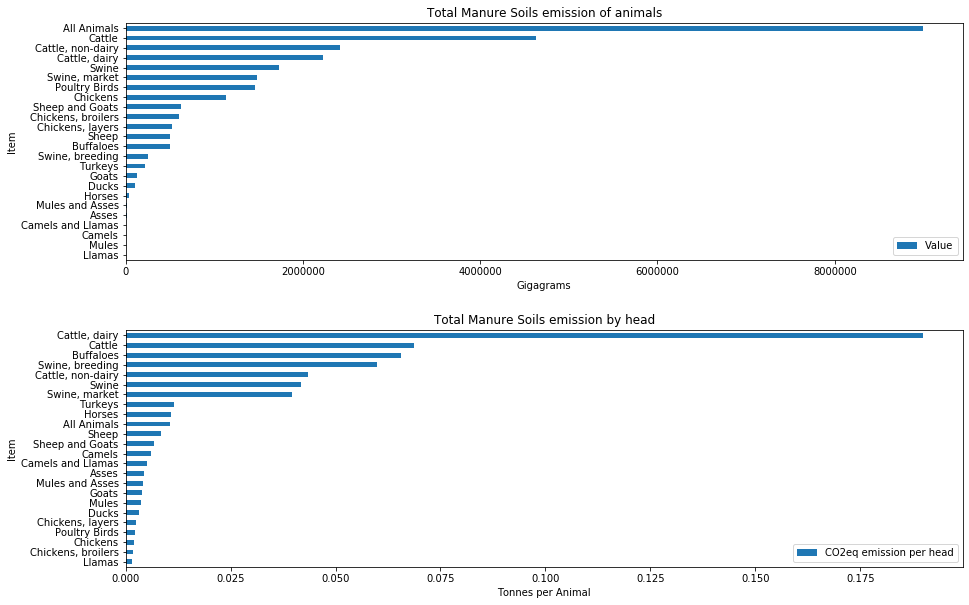

In [183]:
#Grouping stocks count
df_manure_soils_stocks_grouped = (
    dfs_manure_soils_filtered["stocks"]
    .groupby("Item")
    ["Value"]
    .sum()
    .reset_index()
)

df_manure_soils_emission_grouped = (
    dfs_manure_soils_filtered["emissions"]
    .groupby("Item")
    ["Value"]
    .sum()
    .reset_index()
)

df_manure_merged = df_manure_soils_emission_grouped.merge(
    df_manure_soils_stocks_grouped,
    on="Item",
    suffixes=("_emissions", "_stocks")
)

# Convert to tonnes per Animal
df_manure_merged["CO2eq emission per head"] = df_manure_merged["Value_emissions"] / df_manure_merged["Value_stocks"] * 1000

fig, axes = plt.subplots(2, 1, figsize=(15,10))
fig.subplots_adjust(hspace=0.3)

df_manure_soils_emission_grouped.sort_values("Value").plot.barh(
    "Item",
    title="Total Manure Soils emission of animals",
    ax=axes[0]
)
axes[0].set_xlabel("Gigagrams")
axes[0].legend(loc="lower right")

df_manure_merged.sort_values("CO2eq emission per head").plot.barh(
    x="Item",
    y="CO2eq emission per head",
    title="Total Manure Soils emission by head",
    ax=axes[1]
)
axes[1].set_xlabel("Tonnes per Animal")
axes[1].legend(loc="lower right")

### Manure Pasture
The table ‘Manure_Pasture’ contains the following data:

GHG emissions from manure left on pastures consisting of direct and indirect nitrous oxide (N2O) emissions from manure nitrogen (N) left on pastures by grazing livestock.

In [184]:
df_manure_pasture.head()

,Country Code,Country,Item Code,Item,Element Code,Element,Year,Unit,Value,Flag
0,2,Afghanistan,1107,Asses,723602,Indirect emissions (N2O that leaches) (Manure ...,1961,Gigagrams,0.0953,Calculated data
1,2,Afghanistan,1107,Asses,723602,Indirect emissions (N2O that leaches) (Manure ...,1962,Gigagrams,0.0625,Calculated data
2,2,Afghanistan,1107,Asses,723602,Indirect emissions (N2O that leaches) (Manure ...,1963,Gigagrams,0.0734,Calculated data
3,2,Afghanistan,1107,Asses,723602,Indirect emissions (N2O that leaches) (Manure ...,1964,Gigagrams,0.0843,Calculated data
4,2,Afghanistan,1107,Asses,723602,Indirect emissions (N2O that leaches) (Manure ...,1965,Gigagrams,0.0953,Calculated data


#### Checking for null values

In [185]:
print(df_manure_pasture.isna().any())
print("Array of years will null values :",df_manure_pasture[df_manure_pasture["Value"].isna()]["Year"].unique())

#Removing null values(only in predictions)
df_manure_pasture = df_manure_pasture[df_manure_pasture["Year"] < 2030]

Country Code    False
Country         False
Item Code       False
Item            False
Element Code    False
Element         False
Year            False
Unit            False
Value            True
Flag            False
dtype: bool
Array of years will null values : [2030 2050]


#### Element column 

In [186]:
df_manure_pasture["Element"].unique()

array(['Indirect emissions (N2O that leaches) (Manure on pasture)',
       'Indirect emissions (N2O that volatilises) (Manure on pasture)',
       'Manure (N content that leaches) (Manure on pasture)',
       'Manure (N content that volatilises) (Manure on pasture)',
       'Manure (N content) (Manure on pasture)',
       'Implied emission factor for N2O (Manure on pasture)',
       'Direct emissions (N2O) (Manure on pasture)',
       'Direct emissions (CO2eq) (Manure on pasture)',
       'Indirect emissions (N2O) (Manure on pasture)',
       'Indirect emissions (CO2eq) (Manure on pasture)',
       'Emissions (N2O) (Manure on pasture)',
       'Emissions (CO2eq) (Manure on pasture)', 'Stocks'], dtype=object)

Similarly, in the *Element* column we will only be interested in the value of *Stocks* and the value of *Emissions (CO2eq) (Manure on pasture)* which corresponds to the total aggregate of the GHG emission in CO2eq

In [187]:
#Filter the Element Column
dfs_manure_pasture = split_on(
    df_manure_pasture[
        df_manure_pasture["Element"].isin(["Emissions (CO2eq) (Manure on pasture)", "Stocks"])
    ],
    column="Element",
    rename={
        "Stocks": "stocks",
        "Emissions (CO2eq) (Manure on pasture)": "emissions"
    }
)

print("Stock unit :", dfs_manure_pasture.stocks["Unit"].unique())
print("Emission unit :", dfs_manure_pasture.emissions["Unit"].unique())

Stock unit : ['Head']
Emission unit : ['Gigagrams']


#### Item column

We keep only data aggregated on the whole world.

In [188]:
print(df_manure_pasture["Item"].unique())

Animals = df_manure_pasture["Item"].unique()

column_filters = {
    "Country" : ["World"],
    "Item" : Animals
}

dfs_manure_pasture_filtered = DotMap(_dynamic=False)
dfs_manure_pasture_filtered["stocks"] = select_on(
    dfs_manure_pasture["stocks"],
    column_filter_dict=column_filters
)
dfs_manure_pasture_filtered["emissions"] = select_on(
    dfs_manure_pasture["emissions"],
    column_filter_dict=column_filters
)

['Asses' 'Camels' 'Cattle, dairy' 'Cattle, non-dairy' 'Chickens, broilers'
 'Chickens, layers' 'Goats' 'Horses' 'Mules' 'Sheep' 'Buffaloes' 'Ducks'
 'Swine, breeding' 'Swine, market' 'Turkeys' 'Llamas' 'All Animals'
 'Camels and Llamas' 'Cattle' 'Chickens' 'Mules and Asses' 'Poultry Birds'
 'Sheep and Goats' 'Swine']


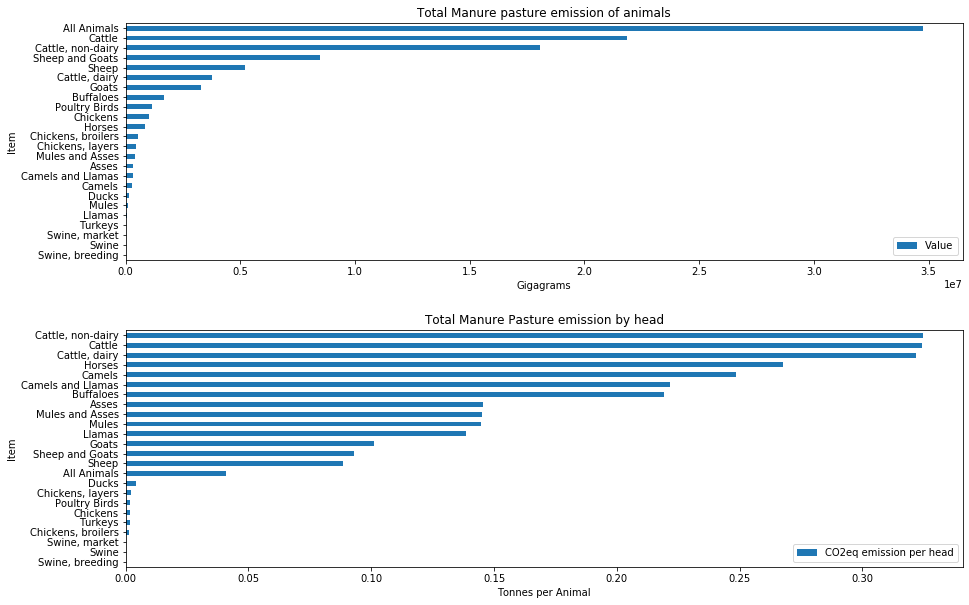

In [189]:
#Grouping stocks count
df_manure_pasture_stocks_grouped = (
    dfs_manure_pasture_filtered["stocks"]
    .groupby("Item")
    ["Value"]
    .sum()
    .reset_index()
)

df_manure_pasture_emission_grouped = (
    dfs_manure_pasture_filtered["emissions"]
    .groupby("Item")
    ["Value"]
    .sum()
    .reset_index()
)

df_pasture_merged = df_manure_pasture_emission_grouped.merge(
    df_manure_pasture_stocks_grouped,
    on="Item",
    suffixes=("_emissions", "_stocks")
)

# Convert to tonnes per animals
df_pasture_merged["CO2eq emission per head"] = df_pasture_merged["Value_emissions"] / df_pasture_merged["Value_stocks"] * 1000

fig, axes = plt.subplots(2, 1, figsize=(15,10))
fig.subplots_adjust(hspace=0.3)

df_manure_pasture_emission_grouped.sort_values("Value").plot.barh(
    "Item",
    title="Total Manure pasture emission of animals",
    ax=axes[0]
)
axes[0].set_xlabel("Gigagrams")
axes[0].legend(loc="lower right")

df_pasture_merged.sort_values("CO2eq emission per head").plot.barh(
    x="Item",
    y="CO2eq emission per head",
    title="Total Manure Pasture emission by head",
    ax=axes[1]
)
axes[1].set_xlabel("Tonnes per Animal")
axes[1].legend(loc="lower right")

### Manure Management
The table ‘Manure_management’ contains the following data:

GHG emissions from manure management consisting of methane and nitrous oxide gases from aerobic and anaerobic manure decomposition processes

In [190]:
df_manure_management.head()

,Country Code,Country,Item Code,Item,Element Code,Element,Year,Unit,Value,Flag
0,2,Afghanistan,1107,Asses,5111,Stocks,1961,Head,1300000.0,Official data
1,2,Afghanistan,1107,Asses,5111,Stocks,1962,Head,851850.0,Official data
2,2,Afghanistan,1107,Asses,5111,Stocks,1963,Head,1001112.0,Official data
3,2,Afghanistan,1107,Asses,5111,Stocks,1965,Head,1300000.0,Official data
4,2,Afghanistan,1107,Asses,5111,Stocks,1966,Head,1200000.0,Official data


#### Checking for null values 

In [191]:
print(df_manure_management.isna().any())
print("Array of years will null values :", df_manure_management[df_manure_management["Value"].isna()]["Year"].unique())

#Removing null values(only in predictions)
df_manure_management = df_manure_management[df_manure_management["Year"] < 2030]

Country Code    False
Country         False
Item Code       False
Item            False
Element Code    False
Element         False
Year            False
Unit            False
Value            True
Flag            False
dtype: bool
Array of years will null values : [2030 2050]


#### Element Column

In [192]:
df_manure_management["Element"].unique()

array(['Stocks', 'Manure (N content) (Manure management)',
       'Implied emission factor for CH4 (Manure management)',
       'Implied emission factor for N2O (Manure management)',
       'Emissions (CH4) (Manure management)',
       'Emissions (CO2eq) from CH4 (Manure management)',
       'Direct emissions (N2O) (Manure management)',
       'Indirect emissions (N2O) (Manure management)',
       'Emissions (N2O) (Manure management)',
       'Direct emissions (CO2eq) (Manure management)',
       'Indirect emissions (CO2eq) (Manure management)',
       'Emissions (CO2eq) from N2O (Manure management)',
       'Emissions (CO2eq) (Manure management)'], dtype=object)

Similarly, in the *Element* column we will only be interested in the value of *Stocks* and the value of *Emissions (CO2eq) (Manure management)* which corresponds to the total aggregate of the GHG emission in CO2eq

In [193]:
#Filter the Element Column
dfs_manure_management = split_on(
    df_manure_management[
        df_manure_management["Element"].isin(["Emissions (CO2eq) (Manure management)", "Stocks"])
    ],
    column="Element",
    rename={
        "Stocks": "stocks",
        "Emissions (CO2eq) (Manure management)": "emissions"
    }
)

print("Stock unit :", dfs_manure_management.stocks["Unit"].unique())
print("Emission unit :", dfs_manure_management.emissions["Unit"].unique())

Stock unit : ['Head']
Emission unit : ['Gigagrams']


#### Item column

We keep only data aggregated on the whole world.

In [194]:
print(df_manure_management["Item"].unique())

Animals = df_manure_management["Item"].unique()

column_filters = {
    "Country" : ["World"],
    "Item" : Animals
}

dfs_manure_management_filtered = DotMap(_dynamic=False)
dfs_manure_management_filtered["stocks"] = select_on(
    dfs_manure_management["stocks"],
    column_filter_dict=column_filters
)
dfs_manure_management_filtered["emissions"] = select_on(
    dfs_manure_management["emissions"],
    column_filter_dict=column_filters
)

['Asses' 'Camels' 'Goats' 'Horses' 'Mules' 'Sheep' 'Buffaloes' 'Ducks'
 'Turkeys' 'Cattle, dairy' 'Cattle, non-dairy' 'Chickens, broilers'
 'Chickens, layers' 'Swine, breeding' 'Swine, market' 'Llamas'
 'All Animals' 'Camels and Llamas' 'Cattle' 'Chickens' 'Mules and Asses'
 'Poultry Birds' 'Sheep and Goats' 'Swine']


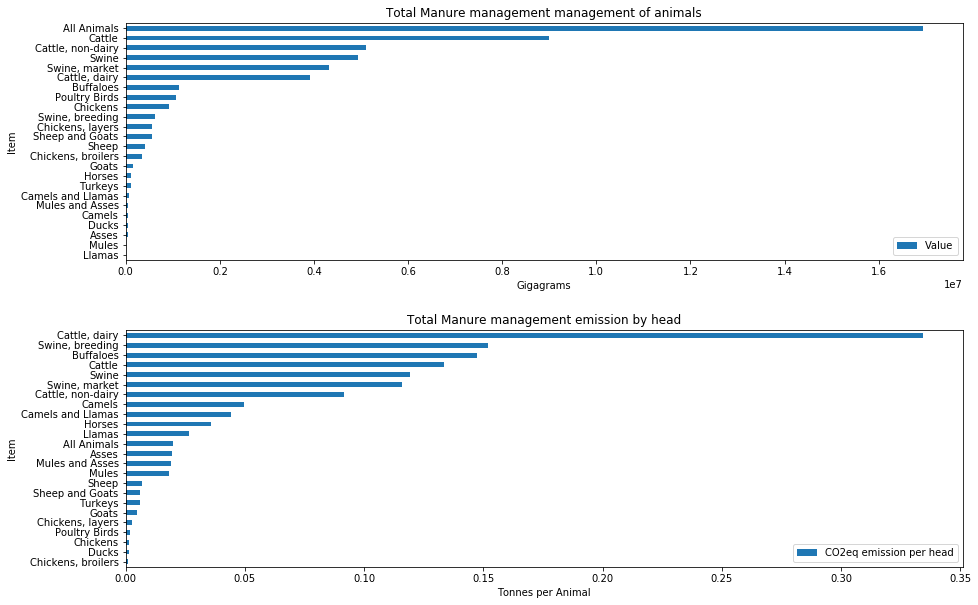

In [195]:
#Grouping stocks count
df_manure_management_stocks_grouped = (
    dfs_manure_management_filtered["stocks"]
    .groupby("Item")
    ["Value"]
    .sum()
    .reset_index()
)

df_manure_management_emission_grouped = (
    dfs_manure_management_filtered["emissions"]
    .groupby("Item")
    ["Value"]
    .sum()
    .reset_index()
)

df_management_merged = df_manure_management_emission_grouped.merge(
    df_manure_pasture_stocks_grouped,
    on="Item",
    suffixes=("_emissions", "_stocks")
)

# Convert to tonnes per animals
df_management_merged["CO2eq emission per head"] = df_management_merged["Value_emissions"] / df_management_merged["Value_stocks"] * 1000

fig, axes = plt.subplots(2, 1, figsize=(15,10))
fig.subplots_adjust(hspace=0.3)

df_manure_management_emission_grouped.sort_values("Value").plot.barh(
    "Item",
    title="Total Manure management management of animals",
    ax=axes[0]
)
axes[0].set_xlabel("Gigagrams")
axes[0].legend(loc="lower right")

df_management_merged.sort_values("CO2eq emission per head").plot.barh(
    x="Item",
    y="CO2eq emission per head",
    title="Total Manure management emission by head",
    ax=axes[1]
)
axes[1].set_xlabel("Tonnes per Animal")
axes[1].legend(loc="lower right")


This tables contain information on animals with defferent level of aggregation. We found in FAO documentation definitions for aggregated animal categories:

- All Animals = Asses	+ Buffaloes + Camels + Cattle, dairy + Cattle, non-dairy + Chickens, broilers + Chickens, layers + Ducks + Goats + Horses + Llamas + Mules + Sheep + Swine, breeding + Swine, market + Turkeys
- Camels and Llamas	=	Camels	+ Llamas
- Cattle = Cattle, dairy +	Cattle, non-dairy
- Chickens	= Chickens, broilers + Chickens, layers	
- Mules and Asses =	Asses + Mules	
- Poultry Birds	= Chickens, broilers	+ Chickens, layers	+ Ducks	+ Turkeys	
- Sheep and Goats =	Goats + Sheep	
- Swine	= Swine, breeding + Swine, market

Because of this mix of raw animals and aggregated categories, we have redundancy in the data.
We want to keep only non overlapping categories. To be compatible with the data we have in the other datasets (production and trade datasets) they must be aggregated to the appropriate level.

Therefore, we keep **'Cattle, dairy', 'Cattle, non-dairy', 'Swine', 'Chickens, layers', 'Chickens, broilers'**, which are among the categories having the most impact in terms of GHG emissions. We will show how we map these living animals categories to their corresponding products.

In [196]:
Animals = ['Cattle, dairy', 'Cattle, non-dairy', 'Swine', 'Chickens, layers', 'Chickens, broilers']

In [197]:
#Filtering all tables to keep only the selected animals
dfs_stock = DotMap(
    {
        "enteric_fermentation": dfs_enteric_fermentation.stocks,
        "manure_management": dfs_manure_management.stocks,
        "manure_pasture": dfs_manure_pasture.stocks,
        "manure_soils": dfs_manure_soils.stocks
    },
    _dynamic=False
)

dfs_emissions = DotMap(
    {
        "enteric_fermentation": dfs_enteric_fermentation.emissions,
        "manure_management": dfs_manure_management.emissions,
        "manure_pasture": dfs_manure_pasture.emissions,
        "manure_soils": dfs_manure_soils.emissions
    },
    _dynamic=False
)

column_filters = {"Item": Animals}
for name, df in dfs_stock.items():
    dfs_stock[name] = select_on(df, column_filter_dict=column_filters)
for name, df in dfs_emissions.items():
    dfs_emissions[name] = select_on(df, column_filter_dict=column_filters)

To focus on a good range of years for our analysis we compute for each year the number of countries where there is available data of livestocks.

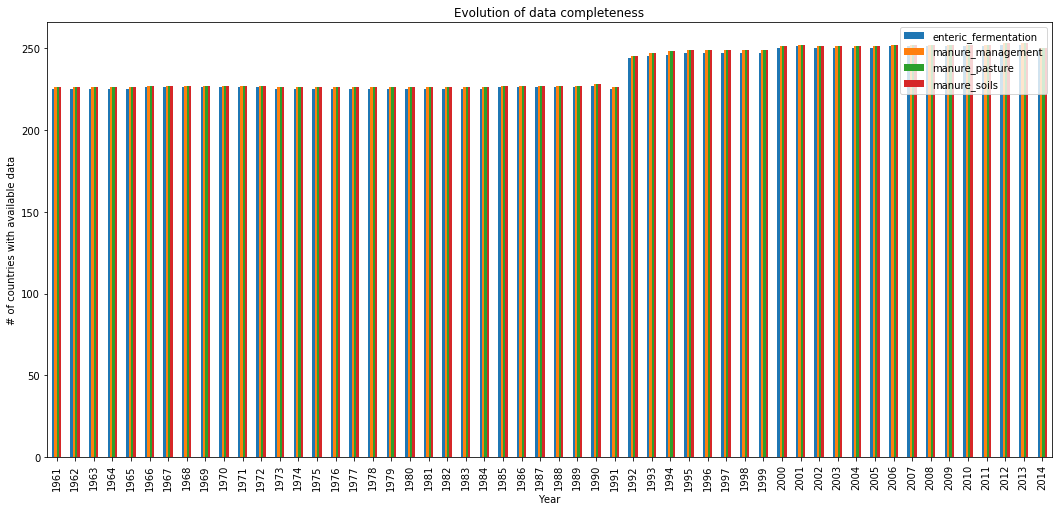

In [198]:
plot_completeness_histogram(dfs_stock, figsize=(18, 8), agg_on="Country Code")

The above histogram showing how complete the data are (number of country with data as a function of time) shows that the data are quite complete. Somme countries seems to have been added in 1992, let's find those.

In [199]:
df = dfs_stock.enteric_fermentation
df_before = df[ df["Year"] == 1991]
df_after = df[ df["Year"] == 1992]

set(df_after["Country"].unique()) - set(df_before["Country"].unique())

{'Armenia',
 'Azerbaijan',
 'Belarus',
 'Bosnia and Herzegovina',
 'Central Asia',
 'Croatia',
 'Estonia',
 'Georgia',
 'Kazakhstan',
 'Kyrgyzstan',
 'Latvia',
 'Lithuania',
 'Republic of Moldova',
 'Russian Federation',
 'Serbia and Montenegro',
 'Slovenia',
 'Tajikistan',
 'The former Yugoslav Republic of Macedonia',
 'Turkmenistan',
 'Ukraine',
 'Uzbekistan'}

This is due to the dilution of the URSS. This will require care in the visualization: the choice of countries to use will most likely be done on a per year basis.

In [200]:
with open('dfs_stock.pkl', 'wb') as f:
        pickle.dump(dfs_stock, f, pickle.HIGHEST_PROTOCOL)
with open('dfs_emissions.pkl', 'wb') as f:
        pickle.dump(dfs_emissions, f, pickle.HIGHEST_PROTOCOL)

## Computed emissions data

In [201]:
# load base info, drop redundant year code column
df_env_emission_intensity = load_df(
    DATA / "global-food-agriculture-statistics/raw_files/Environment_Emissions_intensities_E_All_Data_(Normalized).csv",
    df_flags
).drop("Year Code", axis="columns")

#Remove aggreagated data
df_env_emission_intensity = remove_country_group(df_env_emission_intensity, df_area_groups)

# Split on the Element column
dfs_env_em_intensity = split_on(
    df_env_emission_intensity, "Element",
    drop="Element Code",
    rename=to_snakecase
)
del df_env_emission_intensity
    
for table_name, df in dfs_env_em_intensity.items():
    print(f"\n\nTable {table_name}")
    print(f"  - Units: {', '.join(df['Unit'].unique())}")
    if table_name == "emissions_intensity":
        print("  - Available products:", end="\n      ")
        for k, prod in enumerate(df['Item'].unique()):
            print("%-25s" % prod, end="\n      " if k % 4 == 3 else "")
        print()
    print("  - Sample of 10 values:")
    display(df.sample(10))



Table emissions_intensity
  - Units: kg CO2eq/kg product
  - Available products:
      Cereals excluding rice   Rice, paddy              Meat, cattle             Milk, whole fresh cow    
      Meat, goat               Milk, whole fresh goat   Meat, sheep              Milk, whole fresh sheep  
      Milk, whole fresh camel  Meat, chicken            Eggs, hen, in shell      Milk, whole fresh buffalo
      Meat, pig                Meat, buffalo            
  - Sample of 10 values:


,Area Code,Area,Item Code,Item,Year,Unit,Value,Flag
85344,93,Haiti,1035,"Meat, pig",2000,kg CO2eq/kg product,8.0744,Calculated data
106577,121,Lebanon,1062,"Eggs, hen, in shell",1997,kg CO2eq/kg product,0.4491,Calculated data
95152,105,Israel,1020,"Milk, whole fresh goat",1968,kg CO2eq/kg product,0.7619,Calculated data
51907,51,Czechoslovakia,882,"Milk, whole fresh cow",1980,kg CO2eq/kg product,0.9284,Calculated data
36951,39,Chad,1062,"Eggs, hen, in shell",1983,kg CO2eq/kg product,1.8153,Calculated data
31486,115,Cambodia,27,"Rice, paddy",1977,kg CO2eq/kg product,3.4805,Calculated data
109911,124,Libya,1062,"Eggs, hen, in shell",2009,kg CO2eq/kg product,0.9938,Calculated data
138568,160,Niue,1058,"Meat, chicken",1976,kg CO2eq/kg product,1.3189,Calculated data
175177,206,Sudan (former),1718,Cereals excluding rice,2007,kg CO2eq/kg product,0.1403,Calculated data
68794,69,French Guiana,882,"Milk, whole fresh cow",1992,kg CO2eq/kg product,1.9276,Calculated data




Table emissions_(co2eq)
  - Units: gigagrams
  - Sample of 10 values:


,Area Code,Area,Item Code,Item,Year,Unit,Value,Flag
47676,107,Côte d'Ivoire,1718,Cereals excluding rice,1976,gigagrams,104.1637,Calculated data
182903,216,Thailand,1062,"Eggs, hen, in shell",1965,gigagrams,62.9925,Calculated data
132954,153,New Caledonia,1718,Cereals excluding rice,2010,gigagrams,2.2852,Calculated data
6305,8,Antigua and Barbuda,1058,"Meat, chicken",1968,gigagrams,0.1170,Calculated data
86714,97,Hungary,867,"Meat, cattle",1962,gigagrams,2110.2719,Calculated data
198783,234,Uruguay,1035,"Meat, pig",1983,gigagrams,61.0428,Calculated data
123905,142,Montserrat,1035,"Meat, pig",1982,gigagrams,0.1146,Calculated data
187587,220,Trinidad and Tobago,882,"Milk, whole fresh cow",2011,gigagrams,29.5993,Calculated data
27655,233,Burkina Faso,1718,Cereals excluding rice,1970,gigagrams,130.9050,Calculated data
75826,84,Greece,1020,"Milk, whole fresh goat",1982,gigagrams,837.7116,Calculated data




Table production
  - Units: tonnes
  - Sample of 10 values:


,Area Code,Area,Item Code,Item,Year,Unit,Value,Flag
304496,97,Hungary,1062,"Eggs, hen, in shell",2012,tonnes,133946.0,Official data
322452,211,Switzerland,1017,"Meat, goat",2013,tonnes,507.0,Official data
357323,184,Rwanda,1017,"Meat, goat",1996,tonnes,2200.0,FAO data based on imputation methodology
233113,29,Burundi,1718,Cereals excluding rice,1966,tonnes,150070.0,"Aggregate, may include official, semi-official..."
146419,169,Paraguay,1035,"Meat, pig",1967,tonnes,36807.0,Calculated data
290244,4,Algeria,867,"Meat, cattle",2012,tonnes,135674.0,Official data
203740,243,Wallis and Futuna Islands,1035,"Meat, pig",1966,tonnes,119.0,Calculated data
80941,90,Guinea,1017,"Meat, goat",1974,tonnes,1232.0,Calculated data
300074,60,El Salvador,27,"Rice, paddy",1997,tonnes,66055.0,Official data
318493,183,Romania,1062,"Eggs, hen, in shell",1961,tonnes,120400.0,Official data


[]

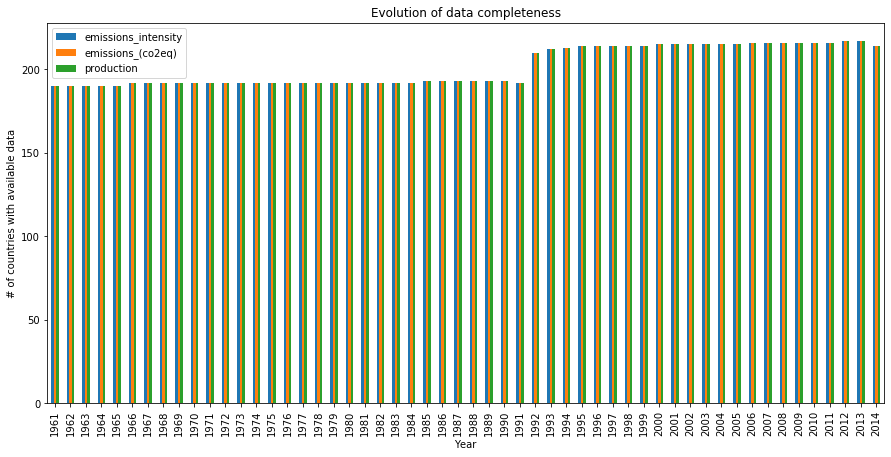

In [202]:
plot_completeness_histogram(dfs_env_em_intensity, figsize=(15, 7))
plt.plot()

The above histogram showing how complete the data are (number of country with data as a function of time) shows that the data are quite complete. Somme countries seems to have been added in 1992, let's find those.

In [203]:
df = dfs_env_em_intensity.production
df_before = df[ df["Year"] == 1991]
df_after = df[ df["Year"] == 1992]

set(df_after["Area"].unique()) - set(df_before["Area"].unique())

{'Armenia',
 'Azerbaijan',
 'Belarus',
 'Bosnia and Herzegovina',
 'Croatia',
 'Estonia',
 'Georgia',
 'Kazakhstan',
 'Kyrgyzstan',
 'Latvia',
 'Lithuania',
 'Republic of Moldova',
 'Russian Federation',
 'Serbia and Montenegro',
 'Slovenia',
 'Tajikistan',
 'The former Yugoslav Republic of Macedonia',
 'Turkmenistan',
 'Ukraine',
 'Uzbekistan'}

This is due to the dilution of the URSS. This will require special handling in the analysis and visualization: the choice of countries to use will most likely be done on a per year basis.

In [204]:
with open('dfs_env_em_intensity.pkl', 'wb') as f:
        pickle.dump(dfs_env_em_intensity, f, pickle.HIGHEST_PROTOCOL)

## Productions

In [205]:
# Load, remove duplicate column "year code"
df_prod_animals = load_df(
    DATA / "global-food-agriculture-statistics/raw_files/Production_LivestockPrimary_E_All_Data_(Normalized).csv",
    df_flags
).drop(columns="Year Code")


#remove aggregated data
df_prod_animals = remove_country_group(df_prod_animals, df_area_groups)

# Harmonise units
## 1000 Head -> Head
unit_filter = df_prod_animals["Unit"] == "1000 Head"
df_prod_animals.loc[unit_filter, "Value"] = df_prod_animals[unit_filter]["Value"].multiply(1000)
df_prod_animals.loc[unit_filter, "Unit"] = "Head"

## 1000 No -> No
unit_filter = df_prod_animals["Unit"] == "1000 No"
df_prod_animals.loc[unit_filter, "Value"] = df_prod_animals[unit_filter]["Value"].multiply(1000)
df_prod_animals.loc[unit_filter, "Unit"] = "No"

## 100mg/An 0.1g/An -> g/An
unit_filter = df_prod_animals["Unit"].isin(["100mg/An", "0.1g/An"])
df_prod_animals.loc[unit_filter, "Value"] = df_prod_animals[unit_filter]["Value"].div(10)
df_prod_animals.loc[unit_filter, "Unit"] = "g/An"

## hg/An -> kg/An
unit_filter = df_prod_animals["Unit"] == "hg/An"
df_prod_animals.loc[unit_filter, "Value"] = df_prod_animals[unit_filter]["Value"].div(10)
df_prod_animals.loc[unit_filter, "Unit"] = "kg/An"

## g/An -> kg/An
unit_filter = df_prod_animals["Unit"] == "g/An"
df_prod_animals.loc[unit_filter, "Value"] = df_prod_animals[unit_filter]["Value"].div(1000)
df_prod_animals.loc[unit_filter, "Unit"] = "kg/An"

## hg -> kg
unit_filter = df_prod_animals["Unit"] == "hg"
df_prod_animals.loc[unit_filter, "Value"] = df_prod_animals[unit_filter]["Value"].div(10)
df_prod_animals.loc[unit_filter, "Unit"] = "kg"

# Split according to Element column
dfs_prod_animals = split_on(
    df_prod_animals,
    "Element",
    rename=to_snakecase
)


for table_name, df in dfs_prod_animals.items():
    print(f"\n\nTable {table_name}")
    print(f"  - Units: {', '.join(df['Unit'].unique())}")
    #if table_name == "production":
    print("  - Available products:", end="\n      ")
    for k, prod in enumerate(df['Item'].unique()):
        print("%-36s" % prod.strip(), end="\n      " if k % 3 == 2 else "")
    print()
    print("  - Sample of 10 values:")
    display(df.sample(10))



Table laying
  - Units: Head
  - Available products:
      Eggs, hen, in shell                 Eggs, other bird, in shell          Eggs, hen, in shell (number)        
      Eggs Primary                        
  - Sample of 10 values:


,Area Code,Area,Item Code,Item,Element Code,Year,Unit,Value,Flag
150308,1,Armenia,1062,"Eggs, hen, in shell",5313,2012,Head,2509000.0,Official data
767855,14,Barbados,1091,"Eggs, other bird, in shell",5313,1979,Head,NaN,Data not available
853249,106,Italy,1783,Eggs Primary,5313,1969,Head,49000000.0,"Aggregate, may include official, semi-official..."
926491,155,Vanuatu,1783,Eggs Primary,5313,1971,Head,44000.0,"Aggregate, may include official, semi-official..."
140823,228,USSR,1062,"Eggs, hen, in shell",5313,1968,Head,328500000.0,FAO estimate
795645,18,Bhutan,1783,Eggs Primary,5313,2005,Head,139000.0,"Aggregate, may include official, semi-official..."
21725,35,Cabo Verde,1062,"Eggs, hen, in shell",5313,1983,Head,60000.0,FAO estimate
173033,51,Czechoslovakia,1062,"Eggs, hen, in shell",5313,1984,Head,22942000.0,Official data
717718,235,Uzbekistan,1062,"Eggs, hen, in shell",5313,1992,Head,20000000.0,Unofficial figure
209004,138,Mexico,1062,"Eggs, hen, in shell",5313,2013,Head,191380000.0,Official data




Table production
  - Units: tonnes, No, Head
  - Available products:
      Eggs, hen, in shell                 Eggs, hen, in shell (number)        Honey, natural                      
      Meat indigenous, camel              Meat indigenous, cattle             Meat indigenous, chicken            
      Meat indigenous, goat               Meat indigenous, sheep              Meat, cattle                        
      Meat, game                          Meat, goat                          Meat, sheep                         
      Milk, whole fresh cow               Milk, whole fresh goat              Milk, whole fresh sheep             
      Silk-worm cocoons, reelable         Wool, greasy                        Eggs, other bird, in shell          
      Eggs, other bird, in shell (number) Meat indigenous, pig                Meat, chicken                       
      Meat, nes                           Meat, pig                           Milk, whole fresh buffalo           
      Mea

,Area Code,Area,Item Code,Item,Element Code,Year,Unit,Value,Flag
908723,206,Sudan (former),1775,"Meat indigenous, poultry",5323,1967,Head,1.218100e+07,"Aggregate, may include official, semi-official..."
921387,225,United Arab Emirates,1775,"Meat indigenous, poultry",5323,1964,Head,6.800000e+04,"Aggregate, may include official, semi-official..."
67290,103,Iraq,1067,"Eggs, hen, in shell (number)",5513,2012,No,1.060000e+09,FAO estimate
819473,48,Costa Rica,1780,"Milk,Total",5510,1968,tonnes,1.780000e+05,"Aggregate, may include official, semi-official..."
95726,153,New Caledonia,867,"Meat, cattle",5510,1973,tonnes,3.150000e+03,FAO estimate
556764,197,Sierra Leone,1070,"Meat indigenous, duck",5510,1964,tonnes,4.900000e+01,Calculated data
291530,18,Bhutan,1094,"Meat indigenous, chicken",5510,1980,tonnes,1.820000e+02,Calculated data
910585,209,Swaziland,1780,"Milk,Total",5510,1975,tonnes,3.200000e+04,"Aggregate, may include official, semi-official..."
806064,39,Chad,1806,Beef and Buffalo Meat,5510,1978,tonnes,3.300000e+04,"Aggregate, may include official, semi-official..."
203203,113,Kyrgyzstan,1055,"Meat indigenous, pig",5322,2005,Head,2.777000e+05,Official data




Table producing_animals/slaughtered
  - Units: Head
  - Available products:
      Hides, cattle, fresh                Meat, camel                         Meat, cattle                        
      Meat, chicken                       Meat, goat                          Meat, sheep                         
      Skins, goat, fresh                  Skins, sheep, fresh                 Meat, pig                           
      Meat, horse                         Meat, rabbit                        Meat, turkey                        
      Meat, duck                          Meat, goose and guinea fowl         Skins, sheep, with wool             
      Hides, buffalo, fresh               Meat, buffalo                       Meat, other camelids                
      Meat, other rodents                 Meat, ass                           Meat, mule                          
      Meat, bird nes                      Meat, game                          Meat, nes                           
  

,Area Code,Area,Item Code,Item,Element Code,Year,Unit,Value,Flag
52750,79,Germany,1017,"Meat, goat",5320,1963,Head,5.525000e+05,FAO estimate
201252,112,Jordan,977,"Meat, sheep",5320,1979,Head,2.530000e+05,Official data
204059,119,Latvia,995,"Skins, sheep, fresh",5320,2005,Head,1.701000e+04,Official data
871296,141,Mongolia,1807,Sheep and Goat Meat,5320,2007,Head,6.302900e+06,"Aggregate, may include official, semi-official..."
219442,162,Norway,1025,"Skins, goat, fresh",5320,1980,Head,2.600000e+04,Official data
60684,91,Guyana,1025,"Skins, goat, fresh",5320,2013,Head,2.760000e+04,FAO estimate
112827,188,Saint Kitts and Nevis,1025,"Skins, goat, fresh",5320,1975,Head,3.450000e+03,FAO estimate
146464,251,Zambia,1017,"Meat, goat",5320,1989,Head,1.542000e+05,FAO estimate
13071,53,Benin,1025,"Skins, goat, fresh",5320,2010,Head,5.200000e+05,FAO estimate
849042,100,India,1808,"Meat, Poultry",5321,2013,Head,2.042410e+09,"Aggregate, may include official, semi-official..."




Table milk_animals
  - Units: Head
  - Available products:
      Milk, whole fresh camel             Milk, whole fresh cow               Milk, whole fresh goat              
      Milk, whole fresh sheep             Milk, whole fresh buffalo           Milk,Total                          
      
  - Sample of 10 values:


,Area Code,Area,Item Code,Item,Element Code,Year,Unit,Value,Flag
774798,118,Kuwait,1130,"Milk, whole fresh camel",5318,2005,Head,NaN,Data not available
888413,170,Peru,1780,"Milk,Total",5318,1975,Head,894322.0,"Aggregate, may include official, semi-official..."
153206,11,Austria,882,"Milk, whole fresh cow",5318,1975,Head,1026122.0,Official data
778576,171,Philippines,951,"Milk, whole fresh buffalo",5318,1994,Head,NaN,Data not available
243634,211,Switzerland,1020,"Milk, whole fresh goat",5318,1966,Head,53288.0,Official data
230674,183,Romania,982,"Milk, whole fresh sheep",5318,2001,Head,5383963.0,Official data
83164,133,Mali,1130,"Milk, whole fresh camel",5318,1972,Head,90000.0,FAO estimate
825458,72,Djibouti,1780,"Milk,Total",5318,1994,Head,46500.0,"Aggregate, may include official, semi-official..."
163775,33,Canada,882,"Milk, whole fresh cow",5318,2000,Head,1103400.0,Official data
83917,134,Malta,882,"Milk, whole fresh cow",5318,1985,Head,7200.0,FAO estimate




Table prod_popultn
  - Units: Head, No
  - Available products:
      Wool, greasy                        Honey, natural                      Beeswax                             
      Silk-worm cocoons, reelable         Hair, horse                         
  - Sample of 10 values:


,Area Code,Area,Item Code,Item,Element Code,Year,Unit,Value,Flag
257065,249,Yemen,987,"Wool, greasy",5319,2006,Head,8197020.0,Official data
771550,56,Dominican Republic,1182,"Honey, natural",5314,1974,No,NaN,Data not available
773967,100,India,1185,"Silk-worm cocoons, reelable",5319,2012,Head,NaN,Data not available
775016,124,Libya,1182,"Honey, natural",5314,1985,No,NaN,Data not available
210027,138,Mexico,987,"Wool, greasy",5319,1982,Head,6642247.0,Official data
33713,47,Cook Islands,1182,"Honey, natural",5314,1981,No,11.0,FAO estimate
772043,59,Egypt,1185,"Silk-worm cocoons, reelable",5319,2005,Head,NaN,Data not available
778836,173,Poland,1185,"Silk-worm cocoons, reelable",5319,1990,Head,NaN,Data not available
101626,165,Pakistan,1182,"Honey, natural",5314,1995,No,86000.0,FAO estimate
772369,66,Fiji,1182,"Honey, natural",5314,1968,No,NaN,Data not available




Table yield
  - Units: kg/An, kg
  - Available products:
      Eggs, hen, in shell                 Hides, cattle, fresh                Milk, whole fresh camel             
      Milk, whole fresh cow               Milk, whole fresh goat              Milk, whole fresh sheep             
      Skins, goat, fresh                  Skins, sheep, fresh                 Wool, greasy                        
      Eggs Primary                        Milk,Total                          Milk, whole fresh buffalo           
      Skins, sheep, with wool             Eggs, other bird, in shell          Hides, buffalo, fresh               
      Honey, natural                      Beeswax                             
  - Sample of 10 values:


,Area Code,Area,Item Code,Item,Element Code,Year,Unit,Value,Flag
517531,169,Paraguay,995,"Skins, sheep, fresh",5420,1963,kg/An,2.5000,Calculated data
624716,249,Yemen,982,"Milk, whole fresh sheep",5420,2004,kg/An,19.9000,Calculated data
264813,5,American Samoa,882,"Milk, whole fresh cow",5420,1969,kg/An,800.0000,Calculated data
398224,87,Guadeloupe,1783,Eggs Primary,5410,1992,kg/An,11.0914,Calculated data
534844,182,Réunion,1783,Eggs Primary,5410,1991,kg/An,11.9891,Calculated data
298304,20,Botswana,1783,Eggs Primary,5410,1966,kg/An,1.8000,Calculated data
445885,121,Lebanon,919,"Hides, cattle, fresh",5420,1972,kg/An,18.0000,Calculated data
317386,33,Canada,987,"Wool, greasy",5422,2010,kg,3.2000,Calculated data
380031,68,France,1780,"Milk,Total",5420,1978,kg/An,2861.8000,Calculated data
536695,183,Romania,995,"Skins, sheep, fresh",5420,1995,kg/An,2.6000,Calculated data




Table yield/carcass_weight
  - Units: kg/An
  - Available products:
      Meat indigenous, camel              Meat indigenous, cattle             Meat indigenous, chicken            
      Meat indigenous, goat               Meat indigenous, sheep              Meat, camel                         
      Meat, cattle                        Meat, chicken                       Meat, goat                          
      Meat, sheep                         Beef and Buffalo Meat               Meat, Poultry                       
      Sheep and Goat Meat                 Meat indigenous, pig                Meat, pig                           
      Meat indigenous, horse              Meat indigenous, rabbit             Meat indigenous, turkey             
      Meat, horse                         Meat, rabbit                        Meat, turkey                        
      Meat indigenous, duck               Meat indigenous, geese              Meat, duck                          
      Meat

,Area Code,Area,Item Code,Item,Element Code,Year,Unit,Value,Flag
400594,89,Guatemala,1012,"Meat indigenous, sheep",5417,2003,kg/An,15.0000,Calculated data
615907,235,Uzbekistan,1808,"Meat, Poultry",5424,2003,kg/An,1.3431,Calculated data
369106,61,Equatorial Guinea,867,"Meat, cattle",5417,1974,kg/An,110.0000,Calculated data
471746,137,Mauritius,1806,Beef and Buffalo Meat,5417,2007,kg/An,234.3000,Calculated data
524796,174,Portugal,944,"Meat indigenous, cattle",5417,1996,kg/An,252.8000,Calculated data
606217,229,United Kingdom,1080,"Meat, turkey",5424,2008,kg/An,9.0746,Calculated data
580699,212,Syrian Arab Republic,972,"Meat indigenous, buffalo",5417,1977,kg/An,110.0000,Calculated data
526775,177,Puerto Rico,944,"Meat indigenous, cattle",5417,1971,kg/An,159.9000,Calculated data
276873,52,Azerbaijan,1808,"Meat, Poultry",5424,1992,kg/An,1.2875,Calculated data
343235,107,Côte d'Ivoire,1035,"Meat, pig",5417,1980,kg/An,35.0000,Calculated data


In [206]:
df_pr = dfs_prod_animals.production
df_y = dfs_prod_animals["yield"]

s = set(df_pr["Item Code"].unique()) -  set(df_y["Item Code"].unique())

df_pr[ df_pr['Item Code'].isin(s)]["Item"].unique()

array(['Eggs, hen, in shell (number)', 'Meat indigenous, camel',
       'Meat indigenous, cattle', 'Meat indigenous, chicken',
       'Meat indigenous, goat', 'Meat indigenous, sheep', 'Meat, cattle',
       'Meat, game', 'Meat, goat', 'Meat, sheep',
       'Silk-worm cocoons, reelable',
       'Eggs, other bird, in shell (number)', 'Meat indigenous, pig',
       'Meat, chicken', 'Meat, nes', 'Meat, pig',
       'Meat indigenous, horse', 'Meat indigenous, rabbit',
       'Meat indigenous, turkey', 'Meat, camel', 'Meat, horse',
       'Meat indigenous, duck', 'Meat indigenous, geese', 'Meat, duck',
       'Meat, turkey', 'Meat, goose and guinea fowl', 'Meat, rabbit',
       'Meat indigenous, buffalo', 'Meat, buffalo',
       'Meat indigenous, other camelids', 'Meat indigenous, rodents',
       'Meat, other camelids', 'Meat indigenous, ass',
       'Meat indigenous, bird nes', 'Meat indigenous, mule', 'Meat, ass',
       'Meat, mule', 'Snails, not sea', 'Meat, bird nes', 'Hair, horse',
 

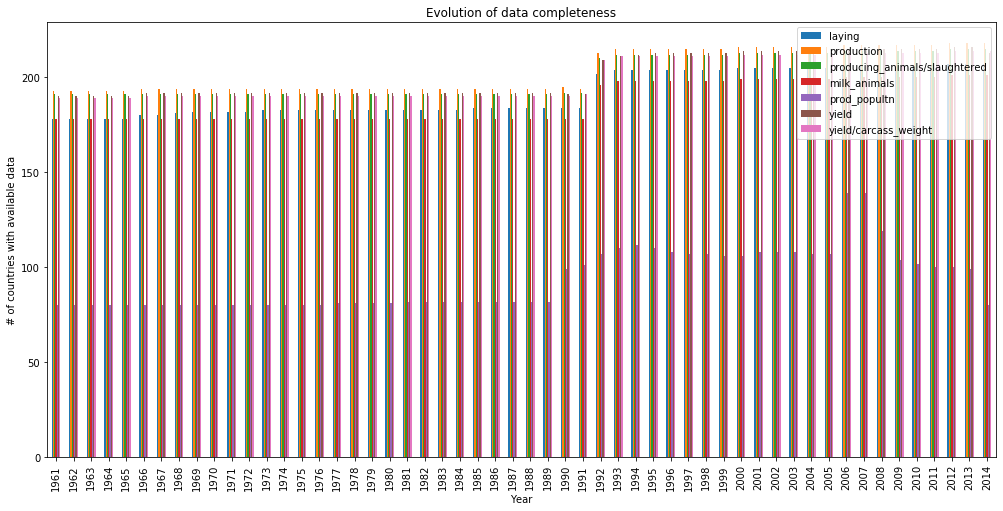

In [207]:
plot_completeness_histogram(dfs_prod_animals, figsize=(17,8))

The above bar plot shows that the `prod_popultn` Table has a lot of missing countries. Given the data it holds, namely the production of `['Wool, greasy', 'Honey, natural', 'Beeswax', 'Silk-worm cocoons, reelable', 'Hair, horse']`, this is not a problem.

The tables we are mostly interested in are `production`, `yield` and `producing_animals/slaughtered`, so we will have to consider only contries at least in those three tables.

In [208]:
with open('dfs_prod_animals.pkl', 'wb') as f:
        pickle.dump(dfs_prod_animals, f, pickle.HIGHEST_PROTOCOL)

## Trade data

In [209]:
raw_trade_matrix = pd.read_csv("data/detailed_trade_matrix/Trade_DetailedTradeMatrix_E_All_Data_NOFLAG.csv", encoding="Latin1")
raw_trade_matrix

,Reporter Country Code,Reporter Countries,Partner Country Code,Partner Countries,Item Code,Item,Element Code,Element,Unit,Y1986,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
0,2,Afghanistan,4,Algeria,230,"Cashew nuts, shelled",5910,Export Quantity,tonnes,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
1,2,Afghanistan,4,Algeria,230,"Cashew nuts, shelled",5922,Export Value,1000 US$,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.0,NaN
2,2,Afghanistan,4,Algeria,1293,Crude materials,5922,Export Value,1000 US$,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,5.0
3,2,Afghanistan,4,Algeria,561,Raisins,5910,Export Quantity,tonnes,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN,NaN
4,2,Afghanistan,4,Algeria,561,Raisins,5922,Export Value,1000 US$,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,27.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5248349,181,Zimbabwe,181,Zimbabwe,667,Tea,5622,Import Value,1000 US$,16.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5248350,181,Zimbabwe,181,Zimbabwe,826,"Tobacco, unmanufactured",5610,Import Quantity,tonnes,254.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5248351,181,Zimbabwe,181,Zimbabwe,826,"Tobacco, unmanufactured",5622,Import Value,1000 US$,571.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5248352,181,Zimbabwe,181,Zimbabwe,565,Vermouths & similar,5610,Import Quantity,tonnes,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [210]:
raw_trade_matrix["Element"].unique()

array(['Export Quantity', 'Export Value', 'Import Quantity',
       'Import Value'], dtype=object)

Detailed trade matrix contains trade information in terms of **quantity** and in terms of **value**. According to FAO documentation, information in terms of value is sometime inconsistent because some countries report values including insurance/transport costs and others report values excluding these costs. Therefore, we will use only **quantity** information.

In [211]:
dfs_trade = split_on(raw_trade_matrix, 
                     "Element", 
                     rename={"Export Quantity":"export","Import Quantity":"import"}, 
                     only_named=True, 
                     drop=["Element Code","Element"])

In [212]:
del raw_trade_matrix

dfs_trade contains two dataframes:
- dfs_trade.export contains trade information reported by exporter country
- dfs_trade.import contains trade information reported by importer country

There is redundancy in this information because a transaction is normally reported both by importer and exporter country.

We want to remove this redundancy, without sacrificing information.

Let us have a look at the amount of information available for each year.

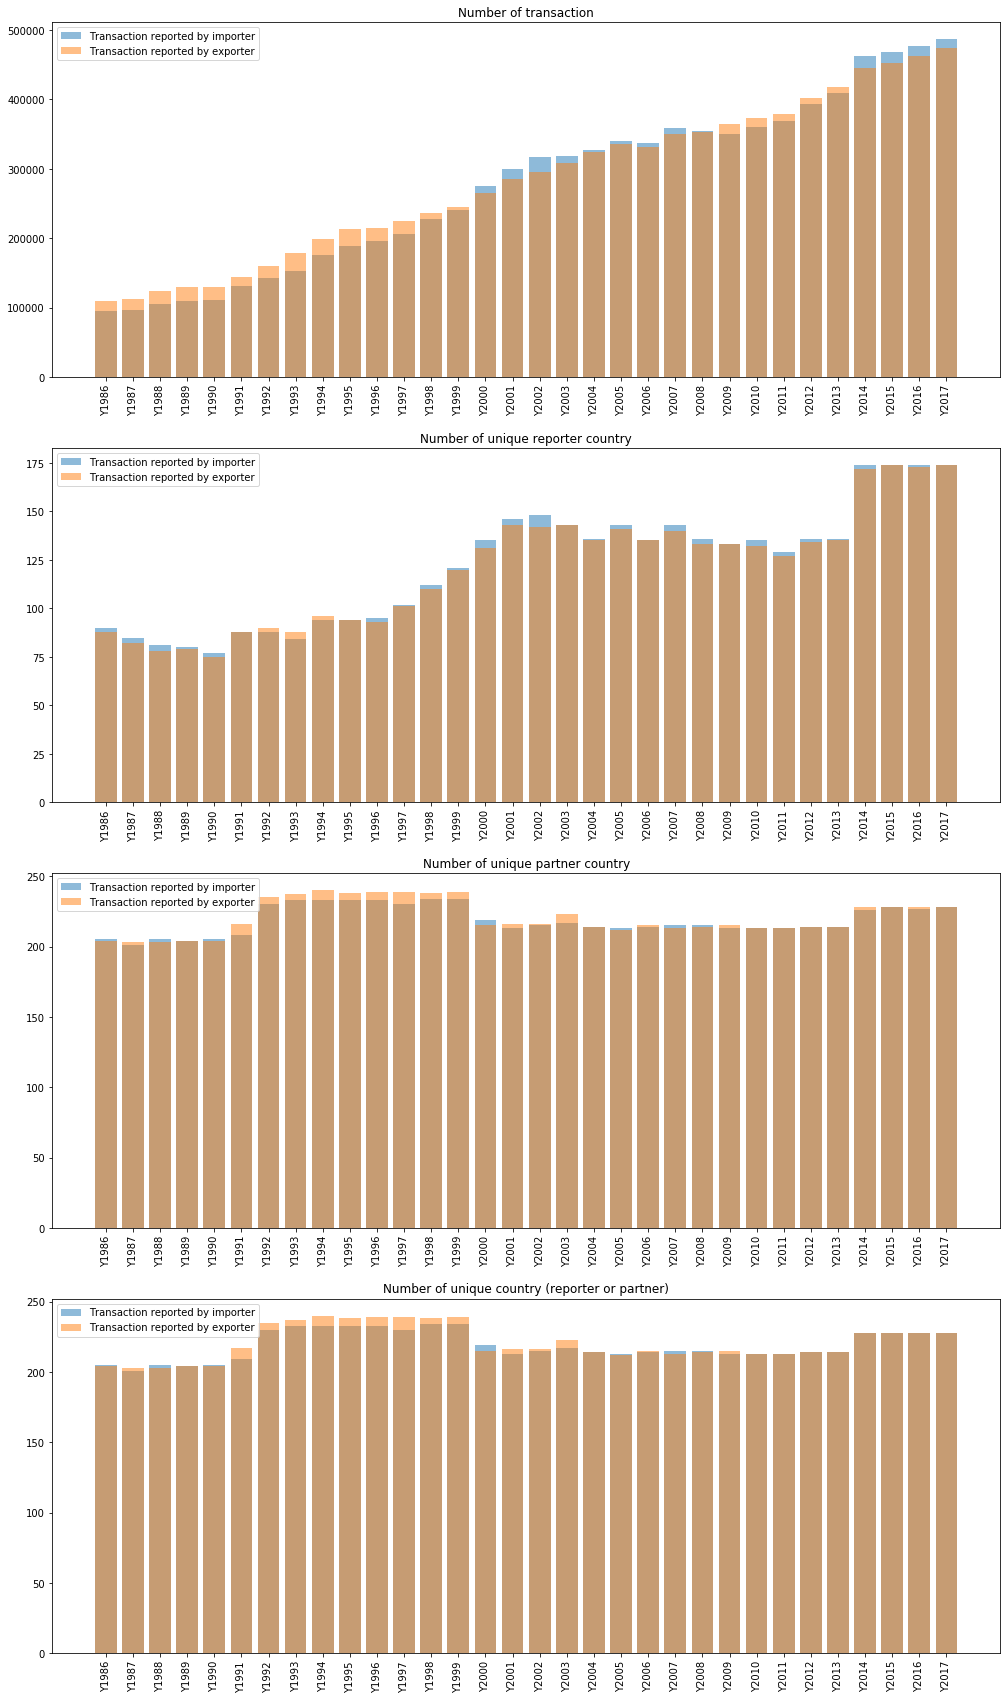

In [213]:
years = ['Y1986', 'Y1987', 'Y1988', 'Y1989', 'Y1990', 'Y1991', 'Y1992', 'Y1993', 'Y1994', 'Y1995', 'Y1996', 'Y1997',
         'Y1998', 'Y1999', 'Y2000', 'Y2001', 'Y2002', 'Y2003', 'Y2004', 'Y2005', 'Y2006', 'Y2007', 'Y2008', 'Y2009',
         'Y2010', 'Y2011', 'Y2012', 'Y2013', 'Y2014', 'Y2015', 'Y2016', 'Y2017']

fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(17,30))

for direction in ["import","export"]:
    n_rows = []
    n_reporter = []
    n_partner = []
    n_countries = []

    for year in years :
        n_rows.append(len(dfs_trade[direction][dfs_trade[direction][year].notna()]))
        reporters = dfs_trade[direction][dfs_trade[direction][year].notna()]["Reporter Countries"].unique()
        partners = dfs_trade[direction][dfs_trade[direction][year].notna()]["Partner Countries"].unique()
        n_reporter.append(len(reporters))
        n_partner.append(len(partners))
        n_countries.append(len(np.unique(np.concatenate((reporters,partners)))))
        
    axs[0].bar(years, n_rows, alpha=0.5)
    axs[0].set_title("Number of transaction")
    axs[1].bar(years, n_reporter, alpha=0.5)
    axs[1].set_title("Number of unique reporter country")
    axs[2].bar(years, n_partner, alpha=0.5)
    axs[2].set_title("Number of unique partner country")
    axs[3].bar(years, n_countries, alpha=0.5)
    axs[3].set_title("Number of unique country (reporter or partner)")

for ax in axs:
    ax.set_xticklabels(labels=years,rotation=90)
    ax.legend(["Transaction reported by importer","Transaction reported by exporter"])
plt.show()

We notice that the number of reporting countries is significatively inferior to the total number of countries involved in trade, especially for the first years of the period.

Therefore, we cannot choose to use either dataframe from import or export point of view, because we would loose information.

We have to combine information from both dataframes. This will enable us to get information about coutries that did not report their transactions.

In [214]:
for direction in ["import","export"]:
    print(direction+" dataframe")
    display(dfs_trade[direction].sample(10))

import dataframe


,Reporter Country Code,Reporter Countries,Partner Country Code,Partner Countries,Item Code,Item,Unit,Y1986,Y1987,Y1988,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
305528,13,Bahrain,229,United Kingdom,626,"Fruit, cooked, homogenized preparations",tonnes,NaN,NaN,NaN,...,NaN,1.0,3.0,2.0,2.0,1.0,3.0,4.0,1.0,2.0
1975963,85,Greenland,174,Portugal,575,Pineapples canned,tonnes,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4099820,200,Singapore,230,Ukraine,469,"Vegetables, dehydrated",tonnes,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.0,NaN
30450,4,Algeria,86,Grenada,1293,Crude materials,tonnes,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5164567,236,Venezuela (Bolivarian Republic of),15,Belgium-Luxembourg,393,Cauliflowers and broccoli,tonnes,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
793828,33,Canada,106,Italy,20,Bread,tonnes,576.0,490.0,239.0,...,562.0,482.0,452.0,491.0,406.0,445.0,451.0,441.0,543.0,539.0
745871,32,Cameroon,159,Nigeria,334,"Oil, linseed",tonnes,NaN,2.0,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4705273,223,Turkey,90,Guinea,18,Macaroni,tonnes,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.0
2599113,118,Kuwait,101,Indonesia,41,"Cereals, breakfast",tonnes,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,5.0,NaN,4.0,14.0,2.0
1510777,238,Ethiopia,121,Lebanon,687,Pepper (piper spp.),tonnes,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN


export dataframe


,Reporter Country Code,Reporter Countries,Partner Country Code,Partner Countries,Item Code,Item,Unit,Y1986,Y1987,Y1988,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
2089421,97,Hungary,146,Republic of Moldova,474,"Vegetables, temporarily preserved",tonnes,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3134488,150,Netherlands,100,India,333,Linseed,tonnes,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,20.0,NaN,NaN,NaN
1624142,68,France,67,Finland,446,"Maize, green",tonnes,NaN,NaN,NaN,...,2.0,2.0,23.0,78.0,12.0,1.0,28.0,21.0,2.0,0.0
4784070,230,Ukraine,116,Democratic People's Republic of Korea,631,"Waters,ice etc",tonnes,NaN,NaN,NaN,...,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2454543,109,Jamaica,55,Dominica,657,"Coffee, roasted",tonnes,NaN,NaN,0.0,...,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
3332531,154,North Macedonia,146,Republic of Moldova,401,"Chillies and peppers, green",tonnes,NaN,NaN,NaN,...,NaN,18.0,NaN,NaN,NaN,5.0,NaN,5.0,NaN,0.0
947679,41,"China, mainland",214,"China, Taiwan Province of",875,"Meat, beef, preparations",tonnes,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4010793,186,Serbia and Montenegro,68,France,534,Peaches and nectarines,tonnes,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5228377,251,Zambia,181,Zimbabwe,882,"Milk, whole fresh cow",tonnes,NaN,NaN,NaN,...,0.0,794.0,1249.0,1455.0,309.0,467.0,685.0,NaN,NaN,NaN
546307,19,Bolivia (Plurinational State of),110,Japan,657,"Coffee, roasted",tonnes,NaN,NaN,NaN,...,NaN,17.0,11.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN


We first transform both dataframes to get a row for each transaction (we "explode" year columns)

In [215]:
for direction in ["import","export"]:
    dfs_trade[direction] = dfs_trade[direction].melt(id_vars=['Reporter Country Code', 'Reporter Countries', 'Partner Country Code',
           'Partner Countries', 'Item Code', 'Item', 'Unit'],var_name="Year", value_name='Quantity')
    dfs_trade[direction] = dfs_trade[direction][dfs_trade[direction]["Quantity"].notna()]
    print(direction+" dataframe")
    display(dfs_trade[direction].sample(10))

import dataframe


,Reporter Country Code,Reporter Countries,Partner Country Code,Partner Countries,Item Code,Item,Unit,Year,Quantity
11617693,137,Mauritius,229,United Kingdom,886,"Butter, cow milk",tonnes,Y1994,21.0
34935615,194,Saudi Arabia,100,India,397,Cucumbers and gherkins,tonnes,Y2011,345.0
25311931,166,Panama,214,"China, Taiwan Province of",1232,Food prep nes,tonnes,Y2004,363.0
39490659,27,Bulgaria,255,Belgium,252,"Oil, coconut (copra)",tonnes,Y2015,0.0
17250039,117,Republic of Korea,216,Thailand,652,"Feed, vegetable products nes",tonnes,Y1998,68.0
29425462,174,Portugal,203,Spain,711,"Anise, badian, fennel, coriander",tonnes,Y2007,40.0
7339718,99,Iceland,223,Turkey,495,"Tangerines, mandarins, clementines, satsumas",tonnes,Y1991,1.0
5550588,15,Belgium-Luxembourg,106,Italy,567,Watermelons,tonnes,Y1990,2779.0
20342520,3,Albania,106,Italy,495,"Tangerines, mandarins, clementines, satsumas",tonnes,Y2001,2023.0
40129827,150,Netherlands,255,Belgium,976,Sheep,Head,Y2015,6.0


export dataframe


,Reporter Country Code,Reporter Countries,Partner Country Code,Partner Countries,Item Code,Item,Unit,Year,Quantity
37242018,97,Hungary,150,Netherlands,634,"Beverages, distilled alcoholic",tonnes,Y2015,1.0
13786253,223,Turkey,50,Cyprus,246,"Groundnuts, prepared",tonnes,Y1996,8.0
9185082,54,Denmark,210,Sweden,295,"Flour, mustard",tonnes,Y1993,86.0
39696272,73,Georgia,179,Qatar,977,"Meat, sheep",tonnes,Y2017,2.0
26954481,63,Estonia,67,Finland,531,Cherries,tonnes,Y2007,5.0
31559232,230,Ukraine,165,Pakistan,191,Chick peas,tonnes,Y2010,87.0
33940920,202,South Africa,185,Russian Federation,634,"Beverages, distilled alcoholic",tonnes,Y2012,10.0
37183787,79,Germany,137,Mauritius,564,Wine,tonnes,Y2015,8.0
24541690,84,Greece,150,Netherlands,687,Pepper (piper spp.),tonnes,Y2005,0.0
36278568,162,Norway,54,Denmark,230,"Cashew nuts, shelled",tonnes,Y2014,1.0


We rename columns concerning "reporter" and "partner" as "exporter" and "importer" for both dataframe according to the direction.

In [216]:
dfs_trade["export"].rename(columns={"Reporter Country Code":"Exporter Code",
                                    "Reporter Countries":"Exporter",
                                    "Partner Country Code":"Importer Code",
                                    "Partner Countries":"Importer"},inplace=True)
dfs_trade["import"].rename(columns={"Reporter Country Code":"Importer Code",
                                    "Reporter Countries":"Importer",
                                    "Partner Country Code":"Exporter Code",
                                    "Partner Countries":"Exporter"},inplace=True)

We merge both dataframe.

In [217]:
trade_matrix = (dfs_trade["import"].merge(dfs_trade["export"],
                      on=["Importer Code","Importer","Exporter Code","Exporter","Item Code","Item","Year"],
                      how="outer",
                      suffixes=(' Importer Report', ' Exporter Report'))
                       [["Importer Code","Importer","Exporter Code","Exporter","Item Code","Item","Year","Unit Importer Report","Quantity Importer Report","Unit Exporter Report","Quantity Exporter Report"]])

In [218]:
del dfs_trade

We now have a unique dataframe for trade information, combining all available reports of transaction from importers and exporters.

According to FAO documentations, there may be some discrepancies between reports from importer and exporter about a transaction (for instance in the case of a loss of part of the load during transport). 
We do not have any reason to trust more one of the reporter. We will therefore keep redundant information when available, and try using in priority on or the other of both dataframe for our study, and see if it affects our results.

The following function return unit and quantity for transaction of `item` between `importer` and `exporter` during `year`, giving `priority` to import or export information if both coutries reported this transaction, or available information if this is not the case. 

In [219]:
def get_value(importer, exporter, year, item, priority, merged_trade_matrix):
    """
    priority = {"import", "export"}
    Information taken in priority from either exporter or importer country report
    """
    #more efficient than standard access
    row = merged_trade_matrix.query(
        "(Importer == @importer) & (Exporter == @exporter) & (Year == @year) & (Item == @item)"
    )
    if priority == "import":
        if row["Quantity Importer Report"].isna().any():
            result = (row[["Unit Exporter Report", "Quantity Exporter Report"]])
        else:
            result = (row[["Unit Importer Report", "Quantity Importer Report"]])
    else:
        if row["Quantity Exporter Report"].isna().any():
            result = (row[["Unit Importer Report", "Quantity Importer Report"]])
        else:
            result = (row[["Unit Exporter Report", "Quantity Exporter Report"]])
    if len(result):
        return tuple(result.iloc[0])
    return np.nan, np.nan

# Products Filtering

In the detailed trade matrix, hundreds of different items are present. Most of them are irrelevant for our study focusing on livestock. We want to avoid having to filter them by hand. We will therefore use the item groups that FAO defined ans used to create aggregated version of the trade matrix.


*(NB: We did not directly use aggregated trade datasets from FAO instead of detailed trade matrix because in these datasets information is also aggregated by coutry so information about trading partner is lost.)*


We load item groups definition from FAO for crop and livestock.

In [220]:
print(len(trade_matrix["Item"].unique()))
trade_matrix["Item"].unique()

423


array(['Flour, wheat', 'Beans, dry', 'Maize', 'Oil, rapeseed',
       'Oil, sunflower', 'Oil, vegetable origin nes', 'Butter, cow milk',
       'Cheese, whole cow milk', 'Crude materials', 'Milk, whole dried',
       'Wool, degreased', 'Wool, greasy', 'Cattle', 'Chickens',
       'Food prep nes', 'Glucose and dextrose', 'Jute',
       'Animals live nes', 'Cake, soybeans', 'Eggs, hen, in shell',
       'Fatty acids', 'Grease incl. lanolin wool',
       'Hides, cattle, wet salted', 'Infant food',
       'Milk, whole condensed', 'Oil, citronella', 'Oil, essential nes',
       'Potatoes', 'Rubber, natural', 'Sugar nes', 'Sugar refined',
       'Tobacco, unmanufactured', 'Cocoa, powder & cake', 'Coffee, green',
       'Oil, castor beans', 'Pepper (piper spp.)',
       'Sugar Raw Centrifugal', 'Meat, cattle, boneless (beef & veal)',
       'Meat, sheep', 'Sheep', 'Milk, skimmed dried',
       'Milk, whole evaporated', 'Oilseeds nes', 'Tallow', 'Wheat', 'Tea',
       'Cigars, cheroots', 'Malt

In [221]:
item_groups_product_with_factor = pd.read_csv("data/definitions_and_standards/item_group_crops_and_livestock_products_with_factor.csv", encoding="Latin1", usecols=["Item Group Code","Item Group","Item Code","Item","Factor"])
item_groups_product_with_factor.drop_duplicates(inplace=True)
print(len(item_groups_product_with_factor["Item Group"].unique()))
item_groups_product_with_factor["Item Group"].unique()

11


array(['Bovine Meat', 'Cassava Equivalent', 'Cereals',
       'Groundnuts Total Shelled', 'Milk Equivalent', 'Pigmeat',
       'Poultry Meat', 'Rice', 'Sugar, Total (Raw Equiv.)', 'Total Meat',
       'Wheat+Flour,Wheat Equivalent'], dtype=object)

Eggs are missing in this dataset. We will build our own item group for eggs.

We look for items related to egg in the complete list of item in trade_matrix by searching for substring "egg".

In [222]:
[item for item in trade_matrix["Item"].unique() if "egg" in item.lower()]

['Eggs, hen, in shell',
 'Eggs, dried',
 'Eggs, liquid',
 'Eggs, other bird, in shell',
 'Eggplants (aubergines)']

In order to have consistent data with production and manure tables, we will only keep items **'Eggs, hen, in shell'**, **'Eggs, dried'** and **'Eggs, liquid'** and aggregate them in a single **'Eggs, equivalent'** item group.

We now have a small number of item group that we can easily filter by hand. We map the selected item groups to animal categories selected at the end of part 4.2.



In [223]:
filter_dict = {"Cattle, non-dairy": "Bovine Meat", "Cattle, dairy": "Milk Equivalent",
               "Swine": "Pigmeat", "Chickens, broilers": "Chicken Meat", "Chickens, layers": "Eggs, equivalent"}

In item group definition, the column factor corresponds to a coefficient we have to apply to quantity during aggregation in order to get equivalent quantity of item group (for instance, 1.3 kg of dry beef corresponds to 1 kg of bovine meat). This will be usefull to make the link between production and trade datasets and living animal stocks.

In [224]:
item_groups_product_with_factor.head()

,Item Group Code,Item Group,Item Code,Item,Factor
0,2071,Bovine Meat,874,"Meat, beef and veal sausages",1.0
2,2071,Bovine Meat,872,"Meat, beef, dried, salted, smoked",1.3
4,2071,Bovine Meat,875,"Meat, beef, preparations",1.3
6,2071,Bovine Meat,947,"Meat, buffalo",1.0
8,2071,Bovine Meat,867,"Meat, cattle",1.0


For the **'Eggs, equivalent'** group, we found in the 
[Weights, Measures, and Conversion Factors for Agricultural Commodities and Their Products (number 697)](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&ved=2ahUKEwir3LaV74_mAhWFLFAKHX-WDxMQFjAAegQIAhAC&url=https%3A%2F%2Fwww.ers.usda.gov%2Fwebdocs%2Fpublications%2F41880%2F33132_ah697_002.pdf%3Fv%3D0&usg=AOvVaw2TF38PIQwrcJPv8CYeCFR-) (page 38) factors to have the equivalent weight for all the eggs items.

In [225]:
egg_items = ['Eggs, hen, in shell', 'Eggs, liquid', 'Eggs, dried']
display(trade_matrix[["Item Code","Item"]][trade_matrix["Item"].isin(egg_items)].groupby(["Item Code","Item"]).count())
egg_codes = [1062, 1063, 1064]
egg_factors = [1,1.57/1.38,1.57/0.35]
egg_group = {"Item Group Code":-1,"Item Group":"Eggs, equivalent","Item Code":egg_codes,"Item":egg_items,"Factor":egg_factors}
egg_group = pd.DataFrame(egg_group)
egg_group

,
Item Code,Item
1062,"Eggs, hen, in shell"
1063,"Eggs, liquid"
1064,"Eggs, dried"


,Item Group Code,Item Group,Item Code,Item,Factor
0,-1,"Eggs, equivalent",1062,"Eggs, hen, in shell",1.000000
1,-1,"Eggs, equivalent",1063,"Eggs, liquid",1.137681
2,-1,"Eggs, equivalent",1064,"Eggs, dried",4.485714


In [226]:
meat_chickens = select_on(item_groups_product_with_factor,
                    {"Item Group": ["Poultry Meat"],
                     "Item": ["Meat, chicken, canned", "Meat, chicken"]})
meat_chickens["Item Group"] = "Chicken Meat"
meat_chickens["Item Group Code"] = -2

In [227]:
item_groups_product_with_factor = item_groups_product_with_factor.append(meat_chickens)
item_groups_product_with_factor = item_groups_product_with_factor.append(egg_group)
item_groups_product_with_factor.reset_index(drop=True)

,Item Group Code,Item Group,Item Code,Item,Factor
0,2071,Bovine Meat,874,"Meat, beef and veal sausages",1.000000
1,2071,Bovine Meat,872,"Meat, beef, dried, salted, smoked",1.300000
2,2071,Bovine Meat,875,"Meat, beef, preparations",1.300000
3,2071,Bovine Meat,947,"Meat, buffalo",1.000000
4,2071,Bovine Meat,867,"Meat, cattle",1.000000
...,...,...,...,...,...
116,-2,Chicken Meat,1058,"Meat, chicken",1.000000
117,-2,Chicken Meat,1061,"Meat, chicken, canned",1.450000
118,-1,"Eggs, equivalent",1062,"Eggs, hen, in shell",1.000000
119,-1,"Eggs, equivalent",1063,"Eggs, liquid",1.137681


We filter trade and production datasets, keeping only rows about items belonging to one of the selected groups.

In [228]:
def filter_itemgroups(df,item_groups_product_with_factor,item_groups):
    """
    Filter the DataFrame df to keep only the items from  the list *item_groups*
    according to the dataframe item_groups_product_with_factor along with their factor
    
    Args:
        df: the dataframe to filter
        item_groups_product_with_factor: a DataFrame with mapping of item -> item_group
        item_groups : list of item_groups to keep
    
    Returns:
        The filtered dataframe
    """
    groups = select_on(item_groups_product_with_factor,
                       {"Item Group": item_groups})
    return df.merge(groups, on=['Item','Item Code'])

In [229]:
live_animals = ["Cattle","Chickens","Pigs"]
trade_matrix_live_animals = select_on(trade_matrix,{"Item":live_animals})

with open('trade_matrix_live_animals.pkl', 'wb') as f:
        pickle.dump(trade_matrix_live_animals, f, pickle.HIGHEST_PROTOCOL)

In [230]:
item_groups = ["Bovine Meat", "Milk Equivalent", "Pigmeat", "Chicken Meat", "Eggs, equivalent"]

#Filtering detail trade table
trade_matrix = filter_itemgroups(trade_matrix,
                                item_groups_product_with_factor,
                                item_groups)   

In [231]:
with open('trade_matrix.pkl', 'wb') as f:
        pickle.dump(trade_matrix, f, pickle.HIGHEST_PROTOCOL)

# Livestock food estimate

Using [http://www.agronext.iastate.edu/immag/pubs/manure-prod-char-d384-2.pdf](http://www.agronext.iastate.edu/immag/pubs/manure-prod-char-d384-2.pdf) and [https://www.ipcc-nggip.iges.or.jp/public/2006gl/pdf/4_Volume4/V4_10_Ch10_Livestock.pdf](https://www.ipcc-nggip.iges.or.jp/public/2006gl/pdf/4_Volume4/V4_10_Ch10_Livestock.pdf) , we can try to estimate the food consuption of some livestock

## Beef

Using the second reference above, page 10.22 Equation 10.18a, we have the estimation of dry matter intake for growing and finishing cattle is:

$$
\begin{align}
    \mathit{DMI} &= \mathit{BW} ^\left(0.75\right) \times \frac{\left(
                    0.2444 \times \mathit{NE}_\mathit{ma}
                     - 0.0111 \times \mathit{NE}_\mathit{ma}^2
                     - 0.472 \right)}{\mathit{NE}_\mathit{ma}}
\end{align}
$$
where:
+ $\mathit{DMI}$: Dry Matter Intake, kg /day
+ $\mathit{BW}$: Live Body Weight, kg
+ $\mathit{NE}_\mathit{ma}$: estimated dietary net energy concentration of diet or default values in Table 10.8, MJ kg-1

Using [http://beefandlamb.ahdb.org.uk/wp/wp-content/uploads/2016/12/BRP-Feeding-growing-and-finishing-manual-7-091216.pdf](http://beefandlamb.ahdb.org.uk/wp/wp-content/uploads/2016/12/BRP-Feeding-growing-and-finishing-manual-7-091216.pdf) we have that the growing period lasts 15 months and from [http://www.agronext.iastate.edu/immag/pubs/manure-prod-char-d384-2.pdf](http://www.agronext.iastate.edu/immag/pubs/manure-prod-char-d384-2.pdf) the finishing period lasts 153 days , we will assume that the body weight grows linearly in a period of 15*30 + 153 = 603 days and using the same document we have that a calf has a starting weight of 86 kg and ends with a weight of 552 kg.

For the $\mathit{NE}_\mathit{ma}$, as we will assume that animals are fed from cereals excluding rice , Table 10.8 gives us an average value of 8 MJ kg-1

In [232]:
def cattle_consumption(days_alive=603, weight_gained=466):
    """
    Yield the food consumption in kg of dry matter of non-dairy cattle
    assuming a linear growth of the cattle weight
    
    Args:
        days_alive: number of days of life of a cattle
        weight_gained: Weight that the cattle gained in days_alive
    
    Returns:
        Series or number (same type as input): the consumption of dry food in kg
    """
    body_weight = []
    dmi = 0
    for i in range(days_alive):
        body_weight.append(86 + i * weight_gained / days_alive)
    for bw in body_weight:
        dmi += bw**0.75 * (0.2444 * 8 - 0.0111 * 64 - 0.472) / 8
    return dmi

In [233]:
cattle_consumption()

4312.566734458839

## Dairy cattle

Using the first reference, table 5c we have on average a dairy cattle has a body weight of 624kg and the DMI is 3.4% of the body weight, this yields a DMI of :

In [234]:
dairy_cattle_consumption_day = 624 * 3.4 / 100
dairy_cattle_consumption_year = dairy_cattle_consumption_day * 365

In [235]:
dairy_cattle_consumption_year

7743.839999999999

## Swine

Similarly using the first reference, we will assume that the weight grows linearly by the number of days. From Table 18b we differenciate between 2 types: Nursery pig with weight from 5kg to 20kg with a DMI of 5% body weight and Grow-finish from 20kg to 120kg with a DMI of 3.4% body weight. The calculation is straightforward:

In [236]:
nursery_pig_consumption = sum([(5 + 15 / 36 * i) * 5 / 100 for i in range(37)])
grow_finish_consumption = sum([(20 + 100 / 120 * i) * 5 / 100 for i in range(121)])
swine_consumption = nursery_pig_consumption + grow_finish_consumption
swine_consumption

446.625

## Poultry
This includes Broilers. The value is given directly in Table 10b of the first document which amounts to 4.05kg of DMI for broilers

In [237]:
broiler_consumption = 4.05

## Poultry (laying hen)

From Table 12b, we have that the DMI of layers is 36.64 kg in a period of 60 weeks, we then calculate the proportional DMI of layers in a year

In [238]:
layer_consumption_year = 52.1429/60 * 36.64
layer_consumption_year

31.841930933333334

# Milestone 3 work

All tasks are per year per country. 

In [239]:
with open("dfs_stock.pkl", 'rb') as f:
    dfs_stock = pickle.load(f)
with open("dfs_emissions.pkl", 'rb') as f:
    dfs_emissions = pickle.load(f)
with open("dfs_env_em_intensity.pkl", 'rb') as f:
    dfs_env_em_intensity = pickle.load(f)
with open("dfs_prod_animals.pkl", 'rb') as f:
    dfs_prod_animals = pickle.load(f)
with open("trade_matrix.pkl", 'rb') as f:
    trade_matrix = pickle.load(f)
with open("trade_matrix_live_animals.pkl", 'rb') as f:
    trade_matrix_live_animals = pickle.load(f)

## Meat Consumption 
*(Trade Matrix + Production Tables)*

- For each country, compute the amount of each item consumed each year. For each item, the amount consumed by a country will be computed by taking the sum of production in the country plus the total amount of imports minus the exports
- For each country, impute the origin of the consumed product. In the case of a country that both exports and imports a given item, we will estimate the repartition of the origin of the consummed goods using this formula:

    + In a given country
    + for a fixed product
    + for a fixed year

$$
    \forall \mathit{origin} ~~
    \quad \quad
    \frac{
        \mathit{Consumption}_\mathit{origin}
    }{
        \mathit{Consumption}_\mathit{total}
    }
    =
    \frac{
        \mathit{Import}_\mathit{origin}
    }{
        \mathit{Production}_\mathit{local}
        + \mathit{Import}_\mathit{total}
    }
$$

In [240]:
def keep_non_redundant_info(trade_matrix):
    """
        Replace columns ["Unit Importer Report","Quantity Importer Report","Unit Exporter Report","Quantity Exporter Report"]
        by columns ["Unit","Quantity"] removing redundance giving priority to info from priority_reporter (in {"importer","exporter"})
    """
    trade_matrix[["Unit (prio importer)","Quantity (prio importer)"]] = trade_matrix[["Unit Importer Report","Quantity Importer Report"]]
    trade_matrix["Unit (prio importer)"].fillna(trade_matrix["Unit Exporter Report"],inplace=True)
    trade_matrix["Quantity (prio importer)"].fillna(trade_matrix["Quantity Exporter Report"],inplace=True)
    
    trade_matrix[["Unit (prio exporter)","Quantity (prio exporter)"]] = trade_matrix[["Unit Exporter Report","Quantity Exporter Report"]]
    trade_matrix["Unit (prio exporter)"].fillna(trade_matrix["Unit Importer Report"],inplace=True)
    trade_matrix["Quantity (prio exporter)"].fillna(trade_matrix["Quantity Importer Report"],inplace=True)
    
    trade_matrix.drop(columns=["Unit Importer Report","Quantity Importer Report","Unit Exporter Report","Quantity Exporter Report"],inplace=True)

#### Import Export Products

In [241]:
keep_non_redundant_info(trade_matrix)

trade_matrix["Year"] = trade_matrix["Year"].apply(lambda str : int(str[1:]))

trade_matrix["Equivalent Quantity (tonnes) (prio importer)"] = trade_matrix["Factor"] * trade_matrix["Quantity (prio importer)"]
trade_matrix["Equivalent Quantity (tonnes) (prio exporter)"] = trade_matrix["Factor"] * trade_matrix["Quantity (prio exporter)"]


item_corresp = {'Milk Equivalent':'Milk, whole fresh cow', 
                'Eggs, equivalent':'Eggs, hen, in shell', 
                'Bovine Meat':'Meat indigenous, cattle', 
                'Pigmeat':'Meat indigenous, pig', 
                'Chicken Meat':'Meat indigenous, chicken'}

trade_matrix.replace(to_replace=item_corresp, inplace=True)
detail_import = (trade_matrix.groupby(by=["Item Group","Importer","Year","Exporter"])
                .sum()[["Equivalent Quantity (tonnes) (prio importer)"]].reset_index())
detail_export = (trade_matrix.groupby(by=["Item Group","Importer","Year","Exporter"])
                 .sum()[["Equivalent Quantity (tonnes) (prio exporter)"]].reset_index())
total_export = detail_export.groupby(by=["Item Group","Year","Exporter"]).sum().reset_index()
## TODO try other priorities

#### Production Meat

##### Ignoring Live Animals trade

In [242]:
# Get the production of meat per country per year
df_meat_prod = select_on(dfs_prod_animals["production"],
                  column_filter_dict={"Item" : ['Meat indigenous, cattle',
                                                'Meat indigenous, chicken',  
                                                'Meat indigenous, pig'],
                                      "Unit":["tonnes"]})

df_meat_prod = df_meat_prod[["Item","Area","Year","Area","Value"]]
df_meat_prod.columns = ["Item","Consumer","Year","Producer","Quantity (tonnes)"]

# Gather all sources in the same dataframe (production by the country itself and importation)
df_meat_cons = select_on(detail_import,
                        column_filter_dict={"Item Group":['Meat indigenous, cattle',
                                                'Meat indigenous, chicken',  
                                                'Meat indigenous, pig']})
df_meat_cons.columns = ["Item","Consumer","Year","Producer","Quantity (tonnes)"]

df_meat_cons = pd.concat([df_meat_cons, df_meat_prod]) 
# TODO groupby and sum for countries that trade with themselves (ex: France import from France)

# Add column total export per consumer per year
total_export.columns = ["Item","Year","Consumer","Export Quantity (tonnes)"]
df_meat_cons = df_meat_cons.merge(total_export)

# Add column total production per consumer per year (production by the country itself and importation)
df_sum_prod = df_meat_cons.groupby(by=["Item","Consumer","Year"]).sum()["Quantity (tonnes)"].reset_index()
df_sum_prod.columns = ["Item","Consumer","Year","Total (all producers)"]
df_meat_cons = df_meat_cons.merge(df_sum_prod)

# Compute consommation as sum of inner production and importation minus exportation allocated to producers 
# according to production ratio 

df_meat_cons["Consumed Quantity (tonnes)"] = (df_meat_cons["Quantity (tonnes)"] 
                                              - df_meat_cons["Export Quantity (tonnes)"]
                                              *df_meat_cons["Quantity (tonnes)"]
                                              /(df_meat_cons["Total (all producers)"])) # df_meat_cons["Stock variation"]

# Get meat yield per animal and convert consumed weight in consumed animal number
df_yield_meat = select_on(dfs_prod_animals["yield/carcass_weight"],
                                 column_filter_dict={"Item":['Meat indigenous, cattle',
                                                             'Meat indigenous, chicken',
                                                             'Meat indigenous, pig']})
df_yield_meat = df_yield_meat[["Item","Year","Area","Value"]]
df_yield_meat.columns = ["Item","Year","Producer","Yield"]

df_meat_cons['Year']=df_meat_cons['Year'].astype(int)
df_yield_meat['Year']=df_yield_meat['Year'].astype(int)

df_meat_cons = df_meat_cons.merge(df_yield_meat)
df_meat_cons["Animal Number"] = 1000 * df_meat_cons["Consumed Quantity (tonnes)"] / df_meat_cons["Yield"]

df_meat_cons.sort_values(by=["Item","Consumer","Year","Animal Number"])

,Item,Consumer,Year,Producer,Quantity (tonnes),Export Quantity (tonnes),Total (all producers),Consumed Quantity (tonnes),Yield,Animal Number
0,"Meat indigenous, cattle",Afghanistan,1992,"China, mainland",13.0,2.60,86436.4,12.999609,155.2,83.760367
35,"Meat indigenous, cattle",Afghanistan,1992,United Kingdom,23.4,2.60,86436.4,23.399296,233.7,100.125358
114,"Meat indigenous, cattle",Afghanistan,1992,Afghanistan,86400.0,2.60,86436.4,86397.401095,180.0,479985.561638
116,"Meat indigenous, cattle",Afghanistan,1995,United States of America,12.0,11.70,130044.0,11.998920,322.7,37.182895
211,"Meat indigenous, cattle",Afghanistan,1995,Afghanistan,130032.0,11.70,130044.0,130020.301080,180.1,721933.931592
...,...,...,...,...,...,...,...,...,...,...
118011,"Meat indigenous, pig",Zimbabwe,2013,United Kingdom,25.0,55.05,36936.8,24.962740,80.9,308.562922
118113,"Meat indigenous, pig",Zimbabwe,2013,United States of America,102.4,55.05,36936.8,102.247385,92.8,1101.803715
117407,"Meat indigenous, pig",Zimbabwe,2013,Brazil,335.8,55.05,36936.8,335.299529,90.0,3725.550324
142590,"Meat indigenous, pig",Zimbabwe,2013,South Africa,4572.2,55.05,36936.8,4565.385668,77.7,58756.572307


In [243]:
sum(df_meat_cons.groupby(by=["Item","Consumer","Year"]).sum()["Consumed Quantity (tonnes)"]<0)

116

In [244]:
len(df_meat_cons.groupby(by=["Item","Consumer","Year"]))

10864

TODO remove ?

In [245]:
df_meat_cons[(df_meat_cons["Consumed Quantity (tonnes)"]<0)].groupby(by=["Item","Consumer","Year"]).sum().reset_index()["Consumer"].unique()

array(['Aruba', 'Belgium-Luxembourg', 'Botswana',
       'British Indian Ocean Territory', 'British Virgin Islands',
       'Brunei Darussalam', 'Croatia', 'Eswatini', 'Namibia', 'Nicaragua',
       'Niue', 'Palestine', 'Saint Vincent and the Grenadines',
       'United Arab Emirates', 'Unspecified Area', 'American Samoa',
       'Belgium', 'Israel', 'Seychelles', 'Antigua and Barbuda',
       'Christmas Island', 'Denmark', 'Eritrea',
       'Falkland Islands (Malvinas)', 'Gambia',
       'Iran (Islamic Republic of)', 'Liechtenstein', 'Pakistan',
       'Sudan (former)', 'Syrian Arab Republic', 'Turkey'], dtype=object)

In [246]:
df_meat_cons[(df_meat_cons["Consumed Quantity (tonnes)"]<0)].groupby(by=["Item","Consumer","Year"]).sum().reset_index()["Year"].unique()

array([1993, 1986, 2007, 2010, 1989, 1990, 1992, 1991, 2001, 2002, 1994,
       1999, 2000, 2012, 2003, 2011, 1987, 1988, 2006, 2008, 2013, 1995,
       1996, 1997, 1998, 2005, 2009, 2004])

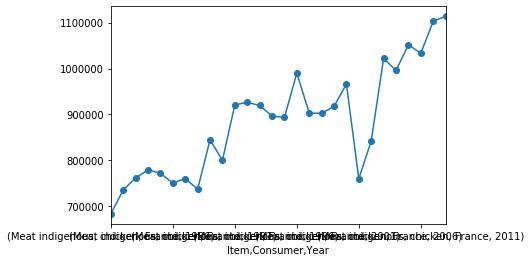

In [247]:
dff = select_on(df_meat_cons, {"Item":["Meat indigenous, chicken"], "Consumer":["France"]})
dff.groupby(by=["Item","Consumer","Year"]).sum()["Consumed Quantity (tonnes)"].plot(marker='o')

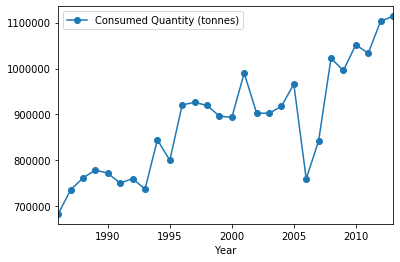

In [248]:
dff.groupby(by=["Item","Consumer","Year"]).sum()["Consumed Quantity (tonnes)"].reset_index()[["Year","Consumed Quantity (tonnes)"]].set_index("Year").plot(marker='o')

In [249]:
dfb = select_on(df_meat_cons, {"Item":["Meat indigenous, chicken"], "Consumer":["Belgium"]})
dfb.groupby(by=["Item","Consumer","Year"]).sum()["Consumed Quantity (tonnes)"]

Item                      Consumer  Year
Meat indigenous, chicken  Belgium   2000    100879.05
                                    2001     88333.35
                                    2002    120123.05
                                    2003    120133.40
                                    2004     87229.85
                                    2005     96466.20
                                    2006     96346.45
                                    2007    117021.50
                                    2008     21510.90
                                    2009     -3263.90
                                    2010    -17258.50
                                    2011     70990.75
                                    2012     70056.10
                                    2013     91329.55
Name: Consumed Quantity (tonnes), dtype: float64

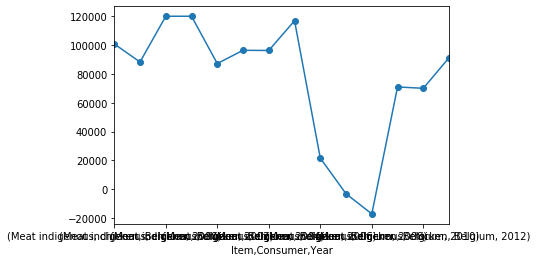

In [250]:
dfb.groupby(by=["Item","Consumer","Year"]).sum()["Consumed Quantity (tonnes)"].plot(marker='o')

In [251]:
df = df_meat_cons[(df_meat_cons["Consumed Quantity (tonnes)"]<0)]

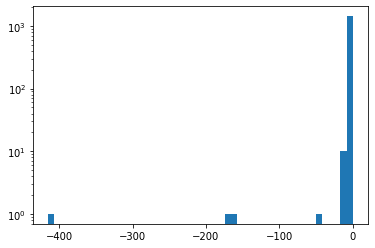

In [252]:
plt.yscale("log")
plt.hist(df["Consumed Quantity (tonnes)"]/df["Total (all producers)"],bins=50)
plt.show()

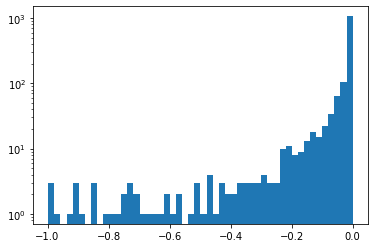

In [253]:
plt.yscale("log")
plt.hist(df["Consumed Quantity (tonnes)"]/df["Export Quantity (tonnes)"],bins=50)
plt.show()

end TODO remove ?

##### Taking Live Animals trade into account

In [254]:
# Get the production of meat per country per year (production from all animals, not only indigenous)
df_meat_prod = select_on(dfs_prod_animals["production"],
                  column_filter_dict={"Item" : ['Meat, cattle',
                                                'Meat, chicken',  
                                                'Meat, pig'],
                                      "Unit":["tonnes"]})

df_meat_prod = df_meat_prod[["Item","Area","Year","Area","Value"]]
df_meat_prod.columns = ["Item","Consumer","Year","Producer","Quantity (tonnes)"]

# Convert item name in trade dataframes to match with item names in production
item_corresp = {'Meat indigenous, cattle':'Meat, cattle', 
                'Meat indigenous, pig':'Meat, pig', 
                'Meat indigenous, chicken':'Meat, chicken'}

detail_import.replace(to_replace=item_corresp, inplace=True)
total_export.replace(to_replace=item_corresp, inplace=True)

# Gather all sources in the same dataframe (production by the country itself and importation)
df_meat_cons = select_on(detail_import,
                        column_filter_dict={"Item Group":['Meat, cattle',
                                                'Meat, chicken',  
                                                'Meat, pig']})
df_meat_cons.columns = ["Item","Consumer","Year","Producer","Quantity (tonnes)"]

df_meat_cons = pd.concat([df_meat_cons, df_meat_prod])

# Add column total export per consumer per year
total_export.columns = ["Item","Year","Consumer","Export Quantity (tonnes)"]
df_meat_cons = df_meat_cons.merge(total_export)

# Add column total production per consumer per year (production by the country itself and importation)
df_sum_prod = df_meat_cons.groupby(by=["Item","Consumer","Year"]).sum()["Quantity (tonnes)"].reset_index()
df_sum_prod.columns = ["Item","Consumer","Year","Total (all producers)"]
df_meat_cons = df_meat_cons.merge(df_sum_prod)

# Compute consommation as sum of inner production and importation minus exportation allocated to producers 
# according to production ratio 
df_meat_cons["Consumed Quantity (tonnes)"] = (df_meat_cons["Quantity (tonnes)"] 
                                              - df_meat_cons["Export Quantity (tonnes)"]
                                              *df_meat_cons["Quantity (tonnes)"]
                                              /df_meat_cons["Total (all producers)"])

# Get meat yield per animal and convert consumed weight in consumed animal number
df_yield_meat = select_on(dfs_prod_animals["yield/carcass_weight"],
                                 column_filter_dict={"Item":['Meat, cattle',
                                                             'Meat, chicken',
                                                             'Meat, pig']})
df_yield_meat = df_yield_meat[["Item","Year","Area","Value"]]
df_yield_meat.columns = ["Item","Year","Producer","Yield"]

df_meat_cons['Year']=df_meat_cons['Year'].astype(int)
df_yield_meat['Year']=df_yield_meat['Year'].astype(int)

df_meat_cons = df_meat_cons.merge(df_yield_meat)
df_meat_cons["Animal Number"] = 1000 * df_meat_cons["Consumed Quantity (tonnes)"] / df_meat_cons["Yield"]

df_meat_cons.sort_values(by=["Item","Consumer","Year","Animal Number"])

,Item,Consumer,Year,Producer,Quantity (tonnes),Export Quantity (tonnes),Total (all producers),Consumed Quantity (tonnes),Yield,Animal Number
0,"Meat, cattle",Afghanistan,1992,"China, mainland",13.0,2.6,86436.4,12.999609,155.2,83.760367
35,"Meat, cattle",Afghanistan,1992,United Kingdom,23.4,2.6,86436.4,23.399296,257.3,90.941687
114,"Meat, cattle",Afghanistan,1992,Afghanistan,86400.0,2.6,86436.4,86397.401095,180.0,479985.561638
116,"Meat, cattle",Afghanistan,1995,United States of America,12.0,11.7,130012.0,11.998920,310.6,38.631423
211,"Meat, cattle",Afghanistan,1995,Afghanistan,130000.0,11.7,130012.0,129988.301080,180.1,721756.252526
...,...,...,...,...,...,...,...,...,...,...
142997,"Meat, pig",Zimbabwe,2014,Italy,0.0,28.5,22905.3,0.000000,121.5,0.000000
154253,"Meat, pig",Zimbabwe,2014,Namibia,0.0,28.5,22905.3,0.000000,55.0,0.000000
183385,"Meat, pig",Zimbabwe,2014,Mozambique,1.7,28.5,22905.3,1.697885,60.0,28.298079
178642,"Meat, pig",Zimbabwe,2014,South Africa,2103.6,28.5,22905.3,2100.982588,80.3,26164.166729


In [255]:
def keep_non_redundant_info_live_animals(trade_matrix_live_animals,priority_reporter,unit):
    ## 1000 Head -> Head
    unit_filter = trade_matrix_live_animals["Unit Importer Report"] == "1000 Head"
    trade_matrix_live_animals.loc[unit_filter, "Quantity Importer Report"] = (trade_matrix_live_animals[unit_filter]
                                                                              ["Quantity Importer Report"].multiply(1000))
    trade_matrix_live_animals.loc[unit_filter, "Unit Importer Report"] = "Head"

    unit_filter = trade_matrix_live_animals["Unit Exporter Report"] == "1000 Head"
    trade_matrix_live_animals.loc[unit_filter, "Quantity Exporter Report"] = (trade_matrix_live_animals[unit_filter]
                                                                              ["Quantity Exporter Report"].multiply(1000))
    trade_matrix_live_animals.loc[unit_filter, "Unit Exporter Report"] = "Head"
    ##
    
    trade_matrix_live_animals_copy = trade_matrix_live_animals.set_index(["Year","Item","Importer","Exporter"])
    #trade_matrix_live_animals_copy.sort_index(inplace=True) #TODO ???

    # df_*reporter*_*unit* contain data from trade_matrix_live_animals that come from *reporter* and with given *unit*
    df_importer_tonnes = select_on(trade_matrix_live_animals_copy,
                                   column_filter_dict={"Unit Importer Report":["tonnes"]}
                                  )[["Unit Importer Report","Quantity Importer Report"]]
    df_importer_tonnes = df_importer_tonnes[~df_importer_tonnes.index.duplicated()]
    df_importer_tonnes.columns = ["Unit","Quantity"]

    df_importer_head = select_on(trade_matrix_live_animals_copy,
                                 column_filter_dict={"Unit Importer Report":["Head"]}
                                )[["Unit Importer Report","Quantity Importer Report"]]
    df_importer_head = df_importer_head[~df_importer_head.index.duplicated()]
    df_importer_head.columns = ["Unit","Quantity"]

    df_exporter_tonnes = select_on(trade_matrix_live_animals_copy,
                                   column_filter_dict={"Unit Exporter Report":["tonnes"]}
                                  )[["Unit Exporter Report","Quantity Exporter Report"]]
    df_exporter_tonnes = df_exporter_tonnes[~df_exporter_tonnes.index.duplicated()]
    df_exporter_tonnes.columns = ["Unit","Quantity"]

    df_exporter_head = select_on(trade_matrix_live_animals_copy,
                                 column_filter_dict={"Unit Exporter Report":["Head"]}
                                )[["Unit Exporter Report","Quantity Exporter Report"]]
    df_exporter_head = df_exporter_head[~df_exporter_head.index.duplicated()]
    df_exporter_head.columns = ["Unit","Quantity"]

    
    # combine all available data removing redundancy, giving priority to priority_reporter and then to unit
    if priority_reporter == "importer":
        if unit == "tonnes":
            res = (df_importer_tonnes
                   .combine_first(df_importer_head)
                   .combine_first(df_exporter_tonnes)
                   .combine_first(df_exporter_head))
        else:
            res = (df_importer_head
                   .combine_first(df_importer_tonnes)
                   .combine_first(df_exporter_head)
                   .combine_first(df_exporter_tonnes))
    else :
        if unit == "tonnes":
            res = (df_exporter_tonnes
                   .combine_first(df_exporter_head)
                   .combine_first(df_importer_tonnes)
                   .combine_first(df_importer_head))
        else:
            res = (df_exporter_head
                   .combine_first(df_exporter_tonnes)
                   .combine_first(df_importer_head)
                   .combine_first(df_importer_tonnes))
    
    res.reset_index(inplace=True)
    
    #TODO conversion Head or tonnes -> unit
    animal_mass_by_country = pd.read_csv("data/definitions_and_standards/TAM_Country.csv", 
                                         encoding="Latin1", 
                                         usecols=["AreaName","Livestock_Type","ParamValue","Units"])
    animal_mass_by_country = select_on(animal_mass_by_country,
                                       column_filter_dict={"Livestock_Type":["Cattle, non-dairy",
                                                                             "Swine, market",
                                                                             "Chicken, broilers"]})
    animal_mass_by_country["Livestock_Type"] = (animal_mass_by_country["Livestock_Type"]
                                                .replace({"Cattle, non-dairy":"Cattle",
                                                          "Swine, market":"Pigs",
                                                          "Chicken, broilers":"Chickens"}))
    animal_mass_by_country.columns = ["Exporter","Item","Animal Mass","Unit Animal Mass"]
    res = res.merge(animal_mass_by_country,how="left")
    res = res.set_index("Item")
    res["Animal Mass"].fillna((animal_mass_by_country[animal_mass_by_country["Exporter"].isna()]
                     .drop_duplicates()
                     .set_index("Item")["Animal Mass"]), inplace=True)
    res["Unit Animal Mass"].fillna((animal_mass_by_country[animal_mass_by_country["Exporter"].isna()]
                     .drop_duplicates()
                     .set_index("Item")["Unit Animal Mass"]), inplace=True)
    res = res.reset_index()
     
    res["Quantity (tonnes)"] = res.apply(lambda r: r["Quantity"] if r["Unit"]== "tonnes" 
                                      else r["Quantity"]*r["Animal Mass"]/1000, axis=1)
    res["Quantity (head)"] = res.apply(lambda r: r["Quantity"] if r["Unit"]== "Head" 
                                      else r["Quantity"]*1000/r["Animal Mass"], axis=1)
    return res[["Item","Year","Importer","Exporter","Quantity (tonnes)","Quantity (head)"]]

df_trade_animals = keep_non_redundant_info_live_animals(trade_matrix_live_animals,"importer","tonnes")

df_trade_animals["Year"] = df_trade_animals["Year"].apply(lambda str : str[1:]).astype(int)

In [256]:
df_trade_animals.columns = ["Item","Year","Area","Producer","Quantity (tonnes)","Quantity (head)"]
df_trade_animals = df_trade_animals[["Item","Year","Area","Producer","Quantity (head)"]]

df_prod_slaughter = select_on(dfs_prod_animals["producing_animals/slaughtered"], 
                              column_filter_dict={"Item":['Meat, cattle', 'Meat, chicken', 'Meat, pig']})
df_prod_slaughter = df_prod_slaughter[["Area","Item","Year","Unit","Value"]]

item_corresp = {'Meat, cattle':"Cattle", 
                'Meat, pig':"Pigs", 
                'Meat, chicken':"Chickens"}

df_prod_slaughter.replace(to_replace=item_corresp, inplace=True)
df_ratio_slaughter = df_prod_slaughter.merge(df_trade_animals)
df_ratio_slaughter["Ratio"] = df_ratio_slaughter["Quantity (head)"]/df_ratio_slaughter["Value"]

In [257]:
remainder = 1 - df_ratio_slaughter.groupby(by=["Area","Item","Year"]).sum()["Ratio"]
remainder = remainder.reset_index()
remainder["Producer"]=remainder["Area"]
df_ratio_slaughter = pd.concat([df_ratio_slaughter,remainder],sort=False)[["Area","Item","Year","Producer","Ratio"]]
df_ratio_slaughter.columns = ["Meat Producer","Item","Year","Animal Producer","Ratio"]
df_ratio_slaughter.head()

,Meat Producer,Item,Year,Animal Producer,Ratio
0,Afghanistan,Chickens,1986,India,0.004024
1,Afghanistan,Chickens,1987,India,0.001605
2,Afghanistan,Chickens,1988,India,0.001250
3,Albania,Chickens,1986,Hungary,0.013168
4,Albania,Chickens,1987,Hungary,0.013137


In [258]:
df_animal_cons = df_meat_cons[["Item","Consumer","Year","Producer","Animal Number"]]
df_animal_cons.columns = ["Item","Consumer","Year","Meat Producer","Animal Number"]
item_corresp = {'Meat, cattle':'Cattle', 
                'Meat, pig':'Pigs', 
                'Meat, chicken':'Chickens'}
df_animal_cons.replace(to_replace=item_corresp, inplace=True)
df_animal_cons.head()

/Users/mac/anaconda3/envs/ada/lib/python3.7/site-packages/pandas/core/frame.py:4263: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


,Item,Consumer,Year,Meat Producer,Animal Number
0,Cattle,Afghanistan,1992,"China, mainland",83.760367
1,Cattle,Argentina,1992,"China, mainland",15.479263
2,Cattle,Australia,1992,"China, mainland",6.904263
3,Cattle,Belarus,1992,"China, mainland",837.067425
4,Cattle,Belize,1992,"China, mainland",0.000000


In [259]:
df_meat_animal_cons = df_animal_cons.merge(df_ratio_slaughter)
df_meat_animal_cons["Number Bred Animal"] = df_meat_animal_cons["Animal Number"] * df_meat_animal_cons["Ratio"]
df_meat_animal_cons = df_meat_animal_cons[["Item","Consumer","Year","Animal Producer","Number Bred Animal"]]
df_meat_animal_cons

,Item,Consumer,Year,Animal Producer,Number Bred Animal
0,Cattle,Afghanistan,1992,Australia,6.711568e-05
1,Cattle,Afghanistan,1992,France,0.000000e+00
2,Cattle,Afghanistan,1992,"China, mainland",8.376030e+01
3,Cattle,Argentina,1992,Australia,1.240326e-05
4,Cattle,Argentina,1992,France,0.000000e+00
...,...,...,...,...,...
1583453,Chickens,American Samoa,1989,New Zealand,-2.222222e+04
1583454,Chickens,American Samoa,1989,American Samoa,-5.277778e+04
1583455,Chickens,Botswana,2005,Zambia,7.000000e+03
1583456,Chickens,Botswana,2005,Zimbabwe,5.800000e+04


In [260]:
sum(df_meat_animal_cons.groupby(by=["Item","Consumer","Year"]).sum()["Number Bred Animal"]<0)

118

In [261]:
len(df_meat_animal_cons.groupby(by=["Item","Consumer","Year"]).sum())

11274

#### Production Egg or Milk

In [262]:
# Get the production of egg and milk per country per year
df_egg_milk_prod = select_on(dfs_prod_animals["production"],
                  column_filter_dict={"Item" : ['Eggs, hen, in shell', 'Milk, whole fresh cow'],
                                      "Unit":["tonnes"]})

df_egg_milk_prod = df_egg_milk_prod[["Item","Area","Year","Area","Value"]]
df_egg_milk_prod.columns = ["Item","Consumer","Year","Producer","Quantity (tonnes)"]

# Gather all sources in the same dataframe (production by the country itself and importation)
df_egg_milk_cons = select_on(detail_import,
                        column_filter_dict={"Item Group":['Eggs, hen, in shell',
                                                'Milk, whole fresh cow']})
df_egg_milk_cons.columns = ["Item","Consumer","Year","Producer","Quantity (tonnes)"]

df_egg_milk_cons = pd.concat([df_egg_milk_cons, df_egg_milk_prod])

# Add column total export per consumer per year
total_export.columns = ["Item","Year","Consumer","Export Quantity (tonnes)"]
df_egg_milk_cons = df_egg_milk_cons.merge(total_export)

# Add column total production per consumer per year (production by the country itself and importation)
df_sum = df_egg_milk_cons.groupby(by=["Item","Consumer","Year"]).sum()["Quantity (tonnes)"].reset_index()
df_sum.columns = ["Item","Consumer","Year","Total (all producers)"]
df_egg_milk_cons = df_egg_milk_cons.merge(df_sum)

# Compute consommation as sum of inner production and importation minus exportation allocated to producers 
# according to production ratio 
df_egg_milk_cons["Consumed Quantity (tonnes)"] = (df_egg_milk_cons["Quantity (tonnes)"] 
                                                  - df_egg_milk_cons["Export Quantity (tonnes)"]
                                                          *df_egg_milk_cons["Quantity (tonnes)"]/
                                                          df_egg_milk_cons["Total (all producers)"])

# Get meat yield per animal and convert consumed weight in consumed animal number
df_yield_egg_milk = select_on(dfs_prod_animals["yield"],
                                 column_filter_dict={"Item":['Eggs, hen, in shell',
                                                             'Milk, whole fresh cow']})
df_yield_egg_milk = df_yield_egg_milk[["Item","Year","Area","Value"]]
df_yield_egg_milk.columns = ["Item","Year","Producer","Yield"]

df_egg_milk_cons['Year']=df_egg_milk_cons['Year'].astype(int)
df_yield_egg_milk['Year']=df_yield_egg_milk['Year'].astype(int)

df_egg_milk_cons = df_egg_milk_cons.merge(df_yield_egg_milk)
df_egg_milk_cons["Animal Number"] = 1000 * df_egg_milk_cons["Consumed Quantity (tonnes)"] / df_egg_milk_cons["Yield"]

df_egg_milk_cons.sort_values(by=["Item","Consumer","Year","Animal Number"])

df_egg_milk_cons.head()

,Item,Consumer,Year,Producer,Quantity (tonnes),Export Quantity (tonnes),Total (all producers),Consumed Quantity (tonnes),Yield,Animal Number
0,"Eggs, hen, in shell",Afghanistan,2000,India,10.000000,2.000000,15537.000000,9.998713,11.6954,854.926958
1,"Eggs, hen, in shell",Algeria,2000,India,44.857143,14.000000,104254.228778,44.851119,11.6954,3834.936738
2,"Eggs, hen, in shell",Argentina,2000,India,107.657143,696.551139,331695.116770,107.431066,11.6954,9185.753856
3,"Eggs, hen, in shell",Australia,2000,India,331.195238,1285.602484,144579.498344,328.250246,11.6954,28066.611352
4,"Eggs, hen, in shell",Austria,2000,India,199.971843,8460.095238,106726.540166,184.120295,11.6954,15742.966896


In [263]:
sum(df_egg_milk_cons.groupby(by=["Item","Consumer","Year"]).sum()["Consumed Quantity (tonnes)"]<0)

57

In [264]:
len(df_egg_milk_cons.groupby(by=["Item","Consumer","Year"]))

8017

In [265]:
df_egg_milk_cons = df_egg_milk_cons[["Item","Consumer","Year","Producer","Animal Number"]]
df_egg_milk_cons.columns = ["Item","Consumer","Year","Animal Producer","Number Bred Animal"]
df_egg_milk_cons.head()

,Item,Consumer,Year,Animal Producer,Number Bred Animal
0,"Eggs, hen, in shell",Afghanistan,2000,India,854.926958
1,"Eggs, hen, in shell",Algeria,2000,India,3834.936738
2,"Eggs, hen, in shell",Argentina,2000,India,9185.753856
3,"Eggs, hen, in shell",Australia,2000,India,28066.611352
4,"Eggs, hen, in shell",Austria,2000,India,15742.966896


#### Final result

In [266]:
df_all_cons = pd.concat([df_egg_milk_cons,df_meat_animal_cons])

item_corresp = {'Milk, whole fresh cow':'Cattle, dairy', 
                'Eggs, hen, in shell':'Chickens, layers', 
                'Cattle':'Cattle, non-dairy', 
                'Pigs':'Swine', 
                'Chickens':'Chickens, broilers'}

df_all_cons.replace(to_replace=item_corresp, inplace=True)

In [267]:
df_all_cons
sum(df_all_cons.groupby(by=["Item","Consumer","Year"]).sum()["Number Bred Animal"]<0)

175

In [268]:
len(df_all_cons.groupby(by=["Item","Consumer","Year"]).sum())

19291

## Animal Productivity 
*(Production Tables + Manure + Enteric fermentation Tables)*

- Aggregate items according to the item groups defined, using factors ("Factor" column) to compute quantity of equivalent product
- Use mapping between products item groups and animal categories to make a link between animal stocks (Manure/Enteric fermentation tables) and products yield(Production Tables)


## Manure + Enteric fermentation Impact 
*(Manure + Enteric fermentation Tables)*

- Get the impact of the existence of animals in terms of C02eq by animal due to the Manure and Enteric fermentation processes

In [269]:
dfs_stock.manure_soils.head(10)

,Country Code,Country,Item Code,Item,Element Code,Year,Unit,Value,Flag
25360,2,Afghanistan,960,"Cattle, dairy",5111,1961,Head,700000.0,FAO estimate
25361,2,Afghanistan,960,"Cattle, dairy",5111,1962,Head,700000.0,FAO estimate
25362,2,Afghanistan,960,"Cattle, dairy",5111,1963,Head,780000.0,FAO estimate
25363,2,Afghanistan,960,"Cattle, dairy",5111,1964,Head,780000.0,FAO estimate
25364,2,Afghanistan,960,"Cattle, dairy",5111,1965,Head,870000.0,FAO estimate
25365,2,Afghanistan,960,"Cattle, dairy",5111,1966,Head,960000.0,FAO estimate
25366,2,Afghanistan,960,"Cattle, dairy",5111,1967,Head,1060000.0,FAO estimate
25367,2,Afghanistan,960,"Cattle, dairy",5111,1968,Head,1080000.0,FAO estimate
25368,2,Afghanistan,960,"Cattle, dairy",5111,1969,Head,1080000.0,FAO estimate
25369,2,Afghanistan,960,"Cattle, dairy",5111,1970,Head,1040000.0,FAO estimate


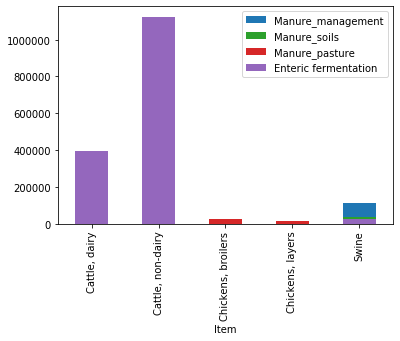

In [270]:
df_enteric_fermentation_emission_clean = dfs_emissions.enteric_fermentation[["Country Code","Country","Item","Year","Value"]]
df_enteric_fermentation_emission_clean = df_enteric_fermentation_emission_clean.rename(columns={"Value":"Enteric fermentation"})
df_manure_management_emission_clean = dfs_emissions.manure_management[["Country Code","Country","Item","Year","Value"]]
df_manure_management_emission_clean = df_manure_management_emission_clean.rename(columns={"Value":"Manure_management"})
df_manure_soils_emission_clean = dfs_emissions.manure_soils[["Country Code","Country","Item","Year","Value"]]
df_manure_soils_emission_clean = df_manure_soils_emission_clean.rename(columns={"Value":"Manure_soils"})
df_manure_pasture_emission_clean = dfs_emissions.manure_pasture[["Country Code","Country","Item","Year","Value"]]
df_manure_pasture_emission_clean = df_manure_pasture_emission_clean.rename(columns={"Value":"Manure_pasture"})
merged_emission = df_manure_management_emission_clean.merge(df_manure_soils_emission_clean,on=["Country","Item","Year", "Country Code"])
merged_emission = merged_emission.merge(df_manure_pasture_emission_clean,on=["Country","Item","Year", "Country Code"])
merged_emission = merged_emission.merge(df_enteric_fermentation_emission_clean,on=["Country","Item","Year", "Country Code"], how="left").fillna(0)
filtered_emission = merged_emission[(merged_emission["Country"]=="World") & (merged_emission["Year"]==2014)]
filtered_emission
ax = filtered_emission.plot.bar(x="Item", y="Manure_management")
filtered_emission.plot.bar(x="Item", y="Manure_soils", ax=ax, color="C2")
filtered_emission.plot.bar(x="Item", y="Manure_pasture", ax=ax, color="C3")
filtered_emission.plot.bar(x="Item", y="Enteric fermentation", ax=ax, color="C4")

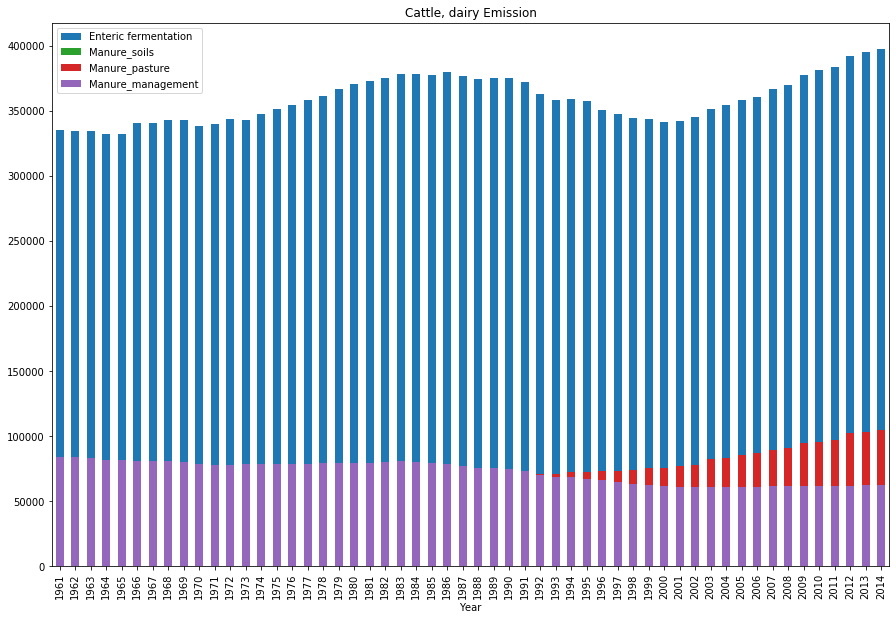

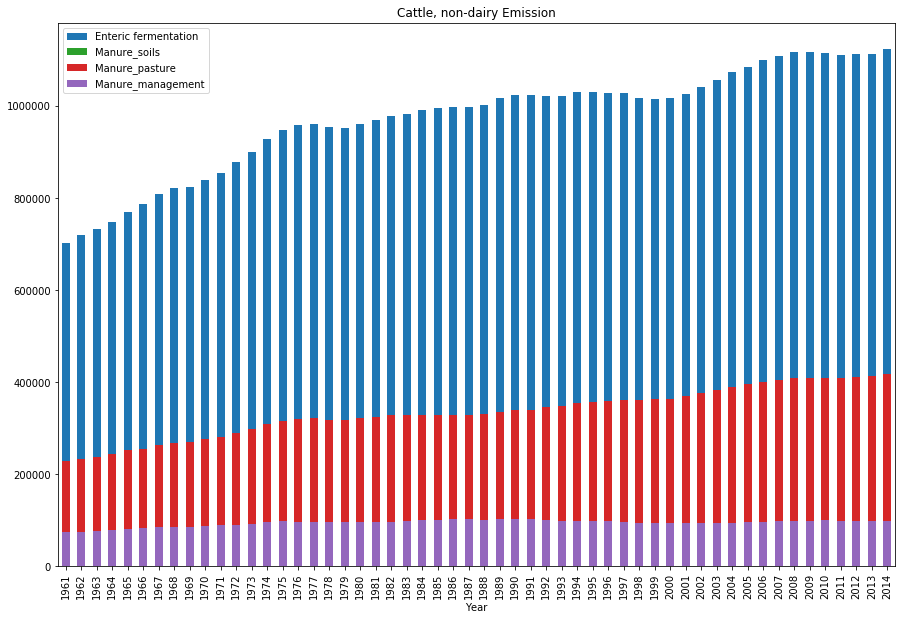

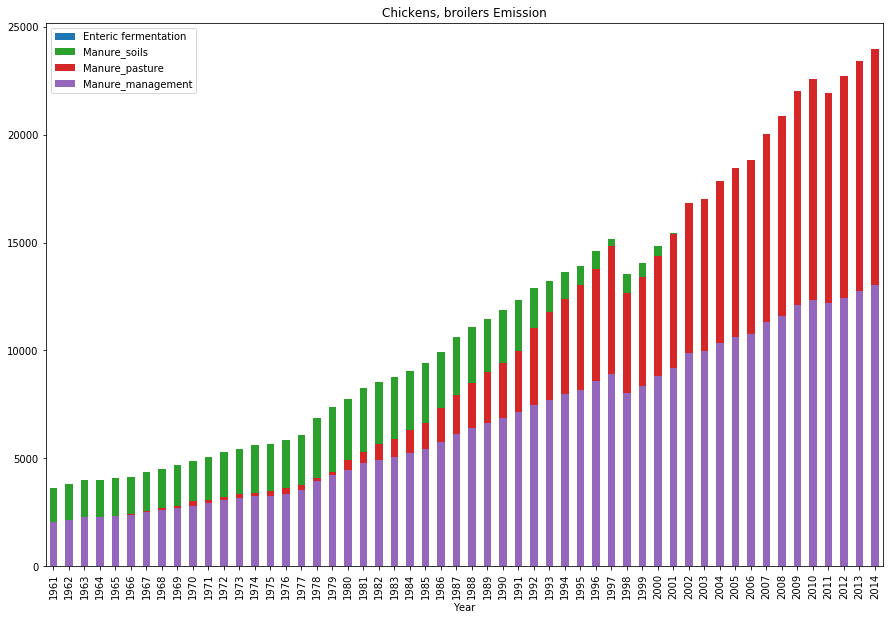

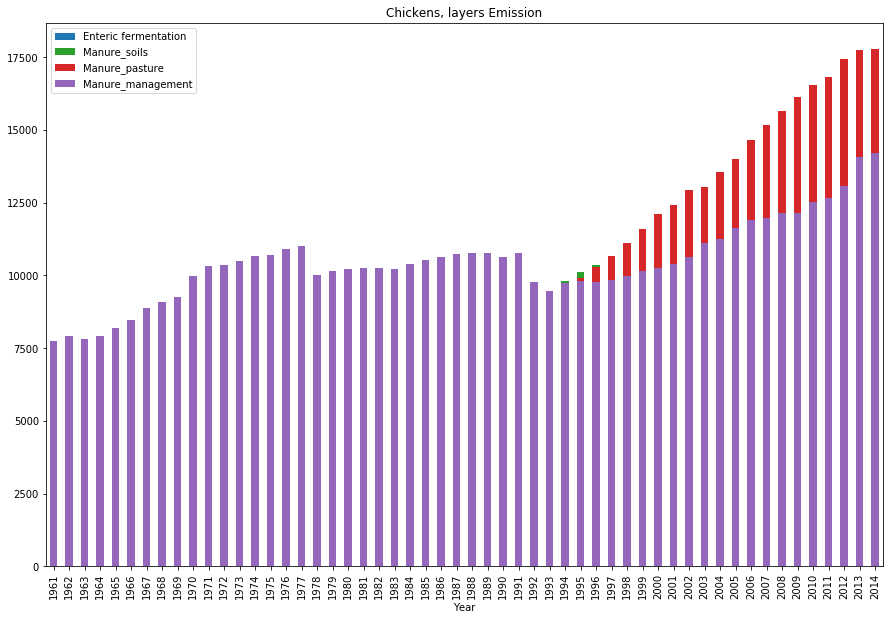

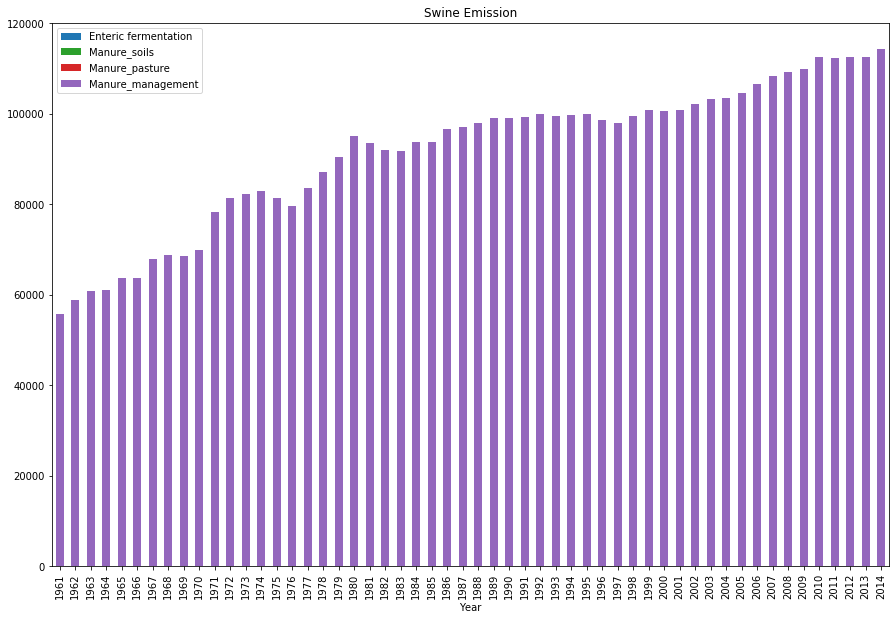

In [271]:
for animal in merged_emission["Item"].unique():
    filtered_emission = merged_emission[(merged_emission["Country"]=="World") & (merged_emission["Item"]==animal)]
    ax = filtered_emission.plot.bar(x="Year", y="Enteric fermentation", figsize=(15,10))
    filtered_emission.plot.bar(x="Year", y="Manure_soils", ax=ax, color="C2")
    filtered_emission.plot.bar(x="Year", y="Manure_pasture", ax=ax, color="C3")
    filtered_emission.plot.bar(x="Year", y="Manure_management", ax=ax, color="C4")
    ax.set_title(str(animal)+" Emission")

In [272]:
df_stock = dfs_stock.manure_soils
df_stock = df_stock[["Country Code","Country","Item","Year","Value"]]
df_stock = df_stock.rename(columns={"Value":"Stock"})
merged_emission = merged_emission.merge(df_stock,on=["Country","Item","Year", "Country Code"], how="left").fillna(0)
merged_emission

,Country Code,Country,Item,Year,Manure_management,Manure_soils,Manure_pasture,Enteric fermentation,Stock
0,2,Afghanistan,"Cattle, dairy",1961,77.0874,37.6414,204.8089,852.6000,700000.0
1,2,Afghanistan,"Cattle, dairy",1962,77.0874,37.6414,204.8089,852.6000,700000.0
2,2,Afghanistan,"Cattle, dairy",1963,85.8974,41.9433,228.2156,950.0400,780000.0
3,2,Afghanistan,"Cattle, dairy",1964,85.8974,41.9433,228.2156,950.0400,780000.0
4,2,Afghanistan,"Cattle, dairy",1965,95.8087,46.7829,254.5482,1059.6600,870000.0
...,...,...,...,...,...,...,...,...,...
61684,5873,OECD,Swine,2010,47340.1655,12852.0594,0.0000,8048.0200,264908395.0
61685,5873,OECD,Swine,2011,47474.6271,12790.8576,0.0000,8014.7016,263364229.0
61686,5873,OECD,Swine,2012,47091.4751,12692.1139,0.0000,7942.4601,261917023.0
61687,5873,OECD,Swine,2013,46648.5332,12586.6297,0.0000,7871.8908,259597006.0


In [273]:
merged_emission["Manure_management_head"] = merged_emission["Manure_management"] / merged_emission["Stock"]
merged_emission["Manure_soils_head"] = merged_emission["Manure_soils"] / merged_emission["Stock"]
merged_emission["Manure_pasture_head"] = merged_emission["Manure_pasture"] / merged_emission["Stock"]
merged_emission["Enteric_fermentation_head"] = merged_emission["Enteric fermentation"] / merged_emission["Stock"]
merged_emission

,Country Code,Country,Item,Year,Manure_management,Manure_soils,Manure_pasture,Enteric fermentation,Stock,Manure_management_head,Manure_soils_head,Manure_pasture_head,Enteric_fermentation_head
0,2,Afghanistan,"Cattle, dairy",1961,77.0874,37.6414,204.8089,852.6000,700000.0,0.000110,0.000054,0.000293,0.001218
1,2,Afghanistan,"Cattle, dairy",1962,77.0874,37.6414,204.8089,852.6000,700000.0,0.000110,0.000054,0.000293,0.001218
2,2,Afghanistan,"Cattle, dairy",1963,85.8974,41.9433,228.2156,950.0400,780000.0,0.000110,0.000054,0.000293,0.001218
3,2,Afghanistan,"Cattle, dairy",1964,85.8974,41.9433,228.2156,950.0400,780000.0,0.000110,0.000054,0.000293,0.001218
4,2,Afghanistan,"Cattle, dairy",1965,95.8087,46.7829,254.5482,1059.6600,870000.0,0.000110,0.000054,0.000293,0.001218
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61684,5873,OECD,Swine,2010,47340.1655,12852.0594,0.0000,8048.0200,264908395.0,0.000179,0.000049,0.000000,0.000030
61685,5873,OECD,Swine,2011,47474.6271,12790.8576,0.0000,8014.7016,263364229.0,0.000180,0.000049,0.000000,0.000030
61686,5873,OECD,Swine,2012,47091.4751,12692.1139,0.0000,7942.4601,261917023.0,0.000180,0.000048,0.000000,0.000030
61687,5873,OECD,Swine,2013,46648.5332,12586.6297,0.0000,7871.8908,259597006.0,0.000180,0.000048,0.000000,0.000030


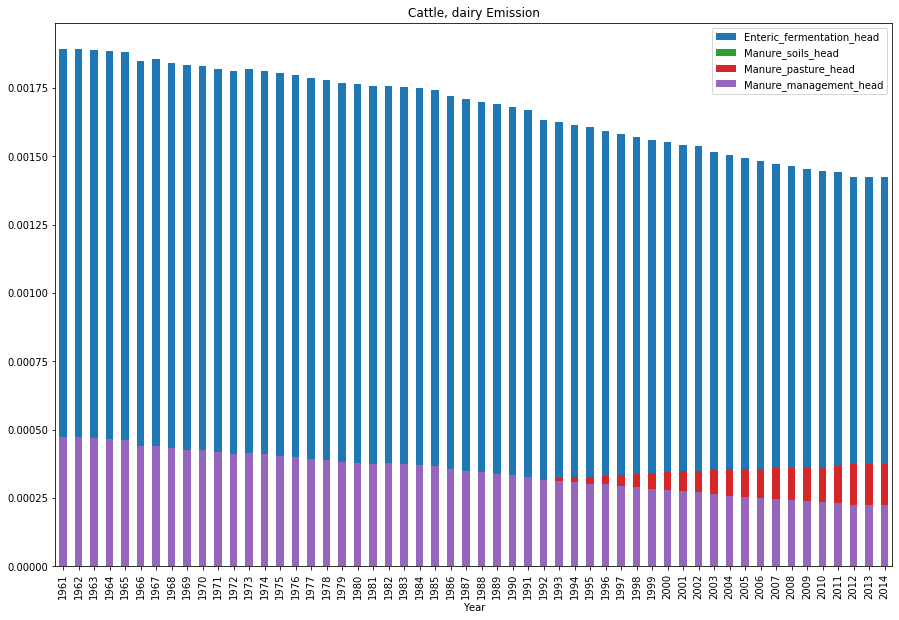

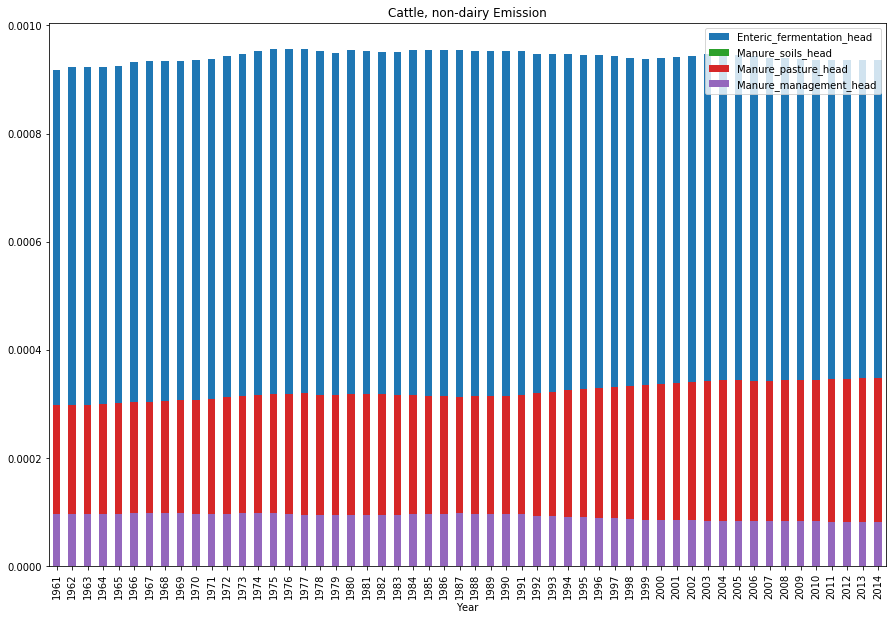

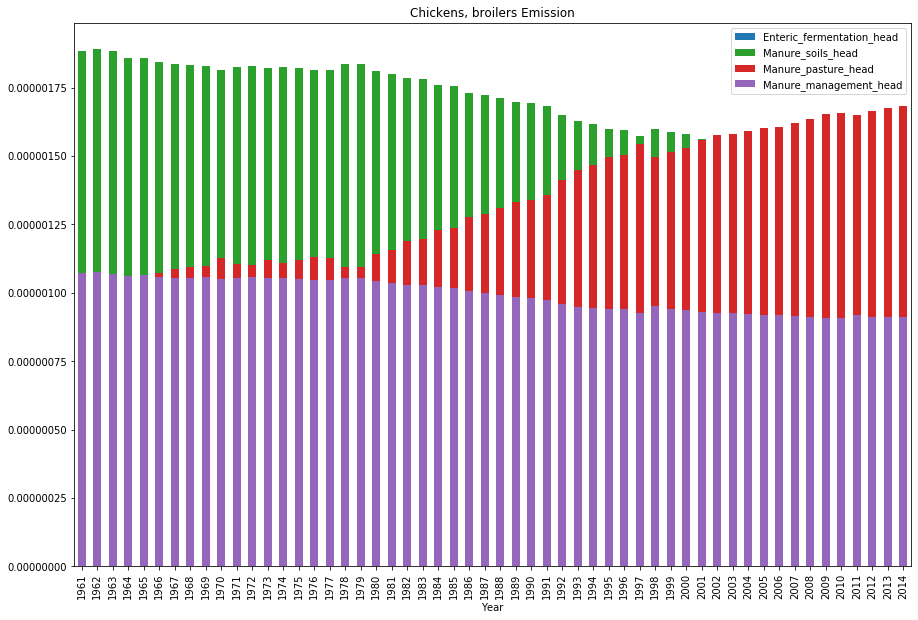

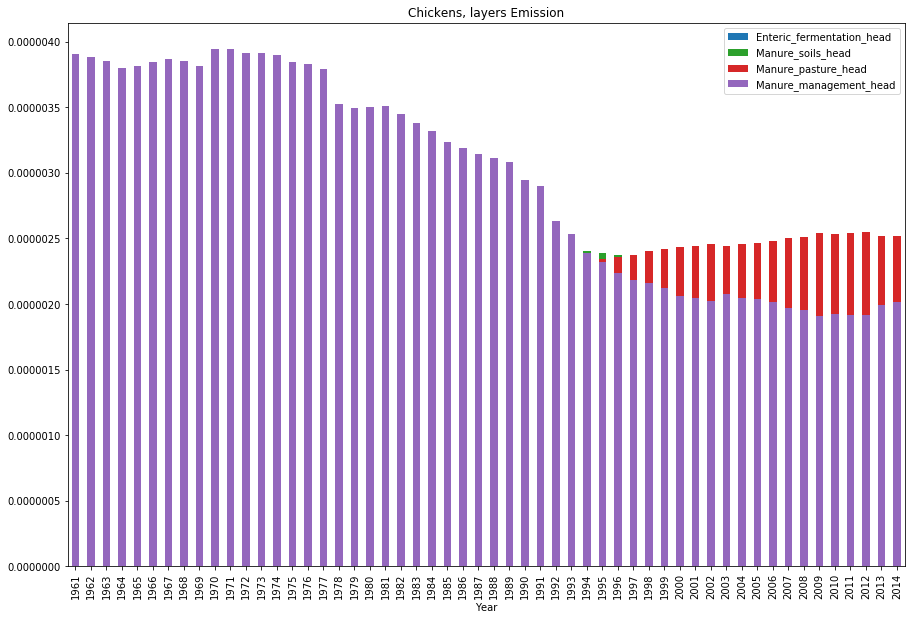

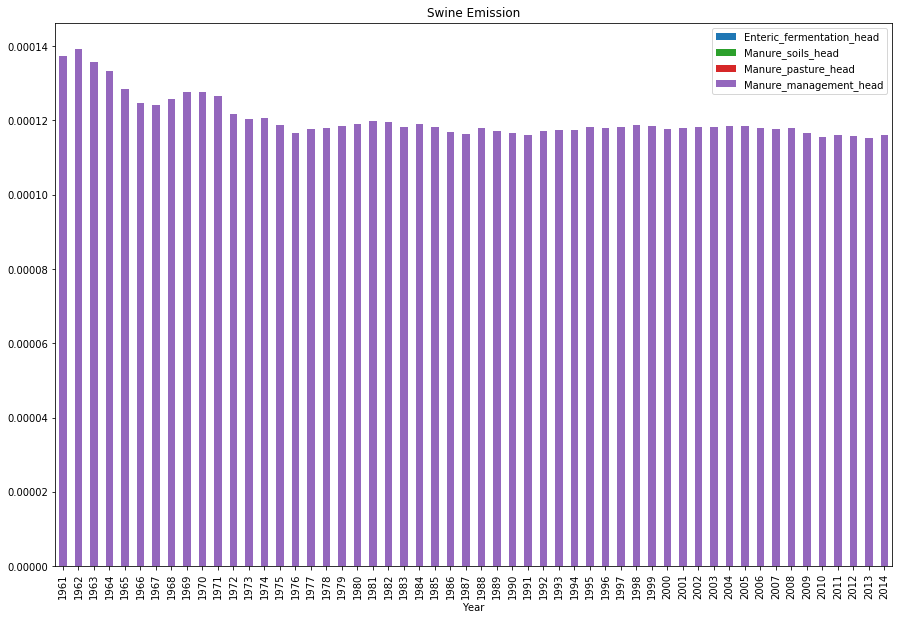

In [274]:
for animal in merged_emission["Item"].unique():
    filtered_emission = merged_emission[(merged_emission["Country"]=="World") & (merged_emission["Item"]==animal)]
    ax = filtered_emission.plot.bar(x="Year", y="Enteric_fermentation_head", figsize=(15,10))
    filtered_emission.plot.bar(x="Year", y="Manure_soils_head", ax=ax, color="C2")
    filtered_emission.plot.bar(x="Year", y="Manure_pasture_head", ax=ax, color="C3")
    filtered_emission.plot.bar(x="Year", y="Manure_management_head", ax=ax, color="C4")
    ax.set_title(str(animal)+" Emission")

In [275]:
import folium

In [276]:
merged_emission

,Country Code,Country,Item,Year,Manure_management,Manure_soils,Manure_pasture,Enteric fermentation,Stock,Manure_management_head,Manure_soils_head,Manure_pasture_head,Enteric_fermentation_head
0,2,Afghanistan,"Cattle, dairy",1961,77.0874,37.6414,204.8089,852.6000,700000.0,0.000110,0.000054,0.000293,0.001218
1,2,Afghanistan,"Cattle, dairy",1962,77.0874,37.6414,204.8089,852.6000,700000.0,0.000110,0.000054,0.000293,0.001218
2,2,Afghanistan,"Cattle, dairy",1963,85.8974,41.9433,228.2156,950.0400,780000.0,0.000110,0.000054,0.000293,0.001218
3,2,Afghanistan,"Cattle, dairy",1964,85.8974,41.9433,228.2156,950.0400,780000.0,0.000110,0.000054,0.000293,0.001218
4,2,Afghanistan,"Cattle, dairy",1965,95.8087,46.7829,254.5482,1059.6600,870000.0,0.000110,0.000054,0.000293,0.001218
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61684,5873,OECD,Swine,2010,47340.1655,12852.0594,0.0000,8048.0200,264908395.0,0.000179,0.000049,0.000000,0.000030
61685,5873,OECD,Swine,2011,47474.6271,12790.8576,0.0000,8014.7016,263364229.0,0.000180,0.000049,0.000000,0.000030
61686,5873,OECD,Swine,2012,47091.4751,12692.1139,0.0000,7942.4601,261917023.0,0.000180,0.000048,0.000000,0.000030
61687,5873,OECD,Swine,2013,46648.5332,12586.6297,0.0000,7871.8908,259597006.0,0.000180,0.000048,0.000000,0.000030


In [277]:
total_emission = merged_emission
total_emission["Total Emissions"] = total_emission[["Enteric fermentation", "Manure_soils", "Manure_soils", "Manure_management"]].sum(axis=1)
total_emission["Total Emissions head"] = total_emission[["Enteric_fermentation_head", "Manure_soils_head", "Manure_soils_head", "Manure_management_head"]].sum(axis=1)
filtered = total_emission[(total_emission["Country Code"]<5000) & (total_emission["Item"]=="Cattle, dairy") & (total_emission["Year"]==2014)]
country_geo = './data/world-countries.json'
map = folium.Map(location=[100, 0], zoom_start=1.5)
map.choropleth(geo_data=country_geo, data=filtered,
             columns=['Country', 'Total Emissions'],
             key_on='properties.name',
             fill_color='YlGnBu', fill_opacity=0.7, line_opacity=0.2)
# Create Folium plot
map.save('cattle_dairy.html')
# Import the Folium interactive html file
from IPython.display import HTML
HTML('<iframe src=cattle_dairy.html width=700 height=450></iframe>')

/Users/mac/anaconda3/envs/ada/lib/python3.7/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning
/Users/mac/anaconda3/envs/ada/lib/python3.7/site-packages/IPython/core/display.py:694: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [278]:
import geopandas as gpd
assert 'naturalearth_lowres' in gpd.datasets.available
datapath = gpd.datasets.get_path('naturalearth_lowres')
gdf = gpd.read_file(datapath)


In [279]:

df_total_emission_map = total_emission[total_emission["Country Code"]<5000]



df_total_emission_map = df_total_emission_map[["Country", "Year", "Total Emissions", "Item"]]
df_total_emission_map = df_total_emission_map[ df_total_emission_map["Item"] == "Cattle, dairy"]
df_total_emission_map = df_total_emission_map.merge(country_iso3,on="Country")

In [280]:
def get_color(country, df, column, item):
    l = []
    
    for year in df["Year"].unique():
        year = int(year)
        val = (df[
                (df["Year"]==year) & (df["Country"]==country) & (df["Item"]==item)
            ])[column]
        if len(val):
            l.append(val.iloc[0])
        else:
            l.append(np.nan)
            
    return np.array(l)
def get_max(df, column, item):
    return df[(df["Item"]==item)][column].max()
get_color("France",df_total_emission_map,"Total Emissions", "Cattle, dairy")


array([28544.2417, 28224.4184, 27384.8818, 27224.9701, 27824.639 ,
       27864.6169, 28664.1756, 28744.1314, 28344.3521, 27984.5506,
       28304.3742, 28751.7272, 29309.4913, 29524.6965, 29554.2202,
       29748.2291, 29392.1937, 29300.9199, 29583.668 , 29039.968 ,
       29028.7303, 28640.1887, 28688.1624, 28012.939 , 26704.2655,
       26017.8284, 24678.388 , 22898.0108, 22471.5943, 22122.2272,
       21279.6883, 20226.1178, 19141.9205, 18758.3321, 18433.8233,
       18149.98  , 17802.172 , 17554.3088, 17494.342 , 16801.6044,
       16843.2094, 16779.6524, 16526.8762, 16011.5606, 15822.6969,
       15502.7096, 15374.7921, 15445.2133, 14983.2723, 14856.9021,
       14648.5251, 14564.7592, 14780.7681, 14898.897 ])

In [281]:
pre = gdf.copy()
pre["index"] = pre.index
df_total_emission_map = pre.merge(df_total_emission_map, right_on="ISO3 Code", left_on="iso_a3")
df_total_emission_map = df_total_emission_map[["index", "Country", "Year", "Total Emissions"]]
df_total_emission_map

,index,Country,Year,Total Emissions
0,0,Fiji,1961,39.9735
1,0,Fiji,1962,39.9735
2,0,Fiji,1963,39.9735
3,0,Fiji,1964,63.9576
4,0,Fiji,1965,63.9576
...,...,...,...,...
7943,175,Trinidad and Tobago,2013,28.8091
7944,175,Trinidad and Tobago,2014,29.2266
7945,176,South Sudan,2012,3376.6864
7946,176,South Sudan,2013,3287.1436


In [ ]:
n_periods = len(df_total_emission_map["Year"].unique())
styledata = {}
datetime_index = pd.date_range('1961-1-1', periods=n_periods, freq='Y')
dt_index_epochs = datetime_index.astype(int) // 10**9
dt_index = dt_index_epochs.astype('U10')


max_ = df_total_emission_map["Total Emissions"].max()



In [ ]:
#%pdb
cmap = linear.PuRd_09.scale(0, int(max_)+1)
legend = cmap.to_step(10)
legend.caption = "Hey !"


df_total_emission_map["Color"] = df_total_emission_map["Total Emissions"].apply(cmap)
styledict = {}
for index in df_total_emission_map["index"].unique():
    data = df_total_emission_map[df_total_emission_map["index"] == index]
    data = data.set_index("Year")["Color"].to_dict()
    data = {str(key) + "-1-1": {"color": item, "opacity": 0.7} for key, item in data.items()}
    styledict[int(index)] = data
from folium.plugins import TimeSliderChoropleth

m = folium.Map([0, 0], tiles='Stamen Toner', zoom_start=2)

g = TimeSliderChoropleth(
    gdf.to_json(),
    styledict=styledict,

).add_to(m)
m.add_child(legend)

#m.save(os.path.join('results', 'TimeSliderChoropleth.html'))

m

In [ ]:
import os
from folium.plugins import TimeSliderChoropleth
country_iso3 = pd.read_csv("data/definitions_and_standards/country_or_region.csv",usecols=["Country","ISO3 Code"])
pre = gdf.copy()
def plot_time_map(df, column, item):
    df = df[["Year","Country", "Item", column]]
    df = df[ df["Item"] == item]
    df = df.merge(country_iso3,on="Country")
    pre["index"] = pre.index
    df = pre.merge(df, right_on="ISO3 Code", left_on="iso_a3")
    df = df[["index", "Country", "Year", column]]
    max_ = df[column].max()
    cmap = linear.PuRd_09.scale(0, int(max_)+1)
    legend = cmap.to_step(10)
    legend.caption = "Hey !"


    df["Color"] = df[column].apply(cmap)
    styledict = {}
    for index in df["index"].unique():
        data = df[df["index"] == index]
        data = data.set_index("Year")["Color"].to_dict()
        data = {str(key) + "-1-1": {"color": item, "opacity": 0.7} for key, item in data.items()}
        styledict[int(index)] = data


    m = folium.Map([0, 0], tiles='Stamen Toner', zoom_start=2)

    g = TimeSliderChoropleth(
        gdf.to_json(),
        styledict=styledict,

    ).add_to(m)
    m.add_child(legend)

    m.save(os.path.join('results', 'TimeSliderChoropleth.html'))

    return m
plot_time_map(total_emission,"Total Emissions", "Cattle, non-dairy")

In [ ]:
filtered = total_emission[(total_emission["Country Code"]<5000) & (total_emission["Item"]=="Cattle, dairy") & (total_emission["Year"]==2014)]
country_geo = './data/world-countries.json'
map = folium.Map(location=[100, 0], zoom_start=1.5)
map.choropleth(geo_data=country_geo, data=filtered,
             columns=['Country', 'Total Emissions head'],
             key_on='properties.name',
             fill_color='YlGnBu', fill_opacity=0.7, line_opacity=0.2)
# Create Folium plot
map.save('cattle_dairy_head.html')
# Import the Folium interactive html file
from IPython.display import HTML
HTML('<iframe src=cattle_dairy_head.html width=700 height=450></iframe>')

In [ ]:
filtered = total_emission[(total_emission["Country Code"]<5000) & (total_emission["Item"]=="Cattle, non-dairy") & (total_emission["Year"]==2014)]
country_geo = './data/world-countries.json'
map = folium.Map(location=[100, 0], zoom_start=1.5)
map.choropleth(geo_data=country_geo, data=filtered,
             columns=['Country', 'Total Emissions'],
             key_on='properties.name',
             fill_color='YlGnBu', fill_opacity=0.7, line_opacity=0.2)
# Create Folium plot
map.save('cattle_non_dairy.html')
# Import the Folium interactive html file
from IPython.display import HTML
HTML('<iframe src=cattle_non_dairy.html width=700 height=450></iframe>')

In [ ]:
filtered = total_emission[(total_emission["Country Code"]<5000) & (total_emission["Item"]=="Cattle, non-dairy") & (total_emission["Year"]==2014)]
country_geo = './data/world-countries.json'
map = folium.Map(location=[100, 0], zoom_start=1.5)
map.choropleth(geo_data=country_geo, data=filtered,
             columns=['Country', 'Total Emissions head'],
             key_on='properties.name',
             fill_color='YlGnBu', fill_opacity=0.7, line_opacity=0.2)
# Create Folium plot
map.save('cattle_non_dairy_head.html')
# Import the Folium interactive html file
from IPython.display import HTML
HTML('<iframe src=cattle_non_dairy_head.html width=700 height=450></iframe>')

In [ ]:
filtered = total_emission[(total_emission["Country Code"]<5000) & (total_emission["Item"]=="Swine") & (total_emission["Year"]==2014)]
country_geo = './data/world-countries.json'
map = folium.Map(location=[100, 0], zoom_start=1.5)
map.choropleth(geo_data=country_geo, data=filtered,
             columns=['Country', 'Total Emissions'],
             key_on='properties.name',
             fill_color='YlGnBu', fill_opacity=0.7, line_opacity=0.2)
# Create Folium plot
map.save('swine.html')
# Import the Folium interactive html file
from IPython.display import HTML
HTML('<iframe src=swine.html width=700 height=450></iframe>')

In [ ]:
filtered = total_emission[(total_emission["Country Code"]<5000) & (total_emission["Item"]=="Swine") & (total_emission["Year"]==2014)]
country_geo = './data/world-countries.json'
map = folium.Map(location=[100, 0], zoom_start=1.5)
map.choropleth(geo_data=country_geo, data=filtered,
             columns=['Country', 'Total Emissions head'],
             key_on='properties.name',
             fill_color='YlGnBu', fill_opacity=0.7, line_opacity=0.2)
# Create Folium plot
map.save('swine_head.html')
# Import the Folium interactive html file
from IPython.display import HTML
HTML('<iframe src=swine_head.html width=700 height=450></iframe>')

In [ ]:
filtered = total_emission[(total_emission["Country Code"]<5000) & (total_emission["Item"]=="Chickens, broilers") & (total_emission["Year"]==2014)]
country_geo = './data/world-countries.json'
map = folium.Map(location=[100, 0], zoom_start=1.5)
map.choropleth(geo_data=country_geo, data=filtered,
             columns=['Country', 'Total Emissions'],
             key_on='properties.name',
             fill_color='YlGnBu', fill_opacity=0.7, line_opacity=0.2)
# Create Folium plot
map.save('chickens_broilers.html')
# Import the Folium interactive html file
from IPython.display import HTML
HTML('<iframe src=chickens_broilers.html width=700 height=450></iframe>')

In [ ]:
filtered = total_emission[(total_emission["Country Code"]<5000) & (total_emission["Item"]=="Chickens, broilers") & (total_emission["Year"]==2014)]
country_geo = './data/world-countries.json'
map = folium.Map(location=[100, 0], zoom_start=1.5)
map.choropleth(geo_data=country_geo, data=filtered,
             columns=['Country', 'Total Emissions head'],
             key_on='properties.name',
             fill_color='YlGnBu', fill_opacity=0.7, line_opacity=0.2)
# Create Folium plot
map.save('chickens_broilers_head.html')
# Import the Folium interactive html file
from IPython.display import HTML
HTML('<iframe src=chickens_broilers_head.html width=700 height=450></iframe>')

In [ ]:
filtered = total_emission[(total_emission["Country Code"]<5000) & (total_emission["Item"]=="Chickens, layers") & (total_emission["Year"]==2014)]
country_geo = './data/world-countries.json'
map = folium.Map(location=[100, 0], zoom_start=1.5)
map.choropleth(geo_data=country_geo, data=filtered,
             columns=['Country', 'Total Emissions'],
             key_on='properties.name',
             fill_color='YlGnBu', fill_opacity=0.7, line_opacity=0.2)
# Create Folium plot
map.save('chickens_layers.html')
# Import the Folium interactive html file
from IPython.display import HTML
HTML('<iframe src=chickens_layers.html width=700 height=450></iframe>')

In [ ]:
filtered = total_emission[(total_emission["Country Code"]<5000) & (total_emission["Item"]=="Chickens, layers") & (total_emission["Year"]==2014)]
country_geo = './data/world-countries.json'
map = folium.Map(location=[100, 0], zoom_start=1.5)
map.choropleth(geo_data=country_geo, data=filtered,
             columns=['Country', 'Total Emissions head'],
             key_on='properties.name',
             fill_color='YlGnBu', fill_opacity=0.7, line_opacity=0.2)
# Create Folium plot
map.save('chickens_layers_head.html')
# Import the Folium interactive html file
from IPython.display import HTML
HTML('<iframe src=chickens_layers_head.html width=700 height=450></iframe>')

In [ ]:
total_emission

## Animal Feeding Impact 
*(Manure Tables + Food Estimations from 6.livestock food estimate + Emission Intensity Table )*

- From the manure table and the food estimations for each animal we get an amount of food required to feed the amount of animals of each country
- We will consider that animals are fed from cereals excluding rice and use the Emission Intensity table to get the CO2eq for producing a given quantity of cereals


In [ ]:
#Merging the values of animal heads of all the manure tables to have consistent values of animal heads
columns = ["Country","Item","Year","Value"]
dfall_stocks = dfs_stock["manure_management"][columns]
for name, df in dfs_stock.items():
    if (name != "enteric_fermentation") : 
        dfall_stocks = dfall_stocks.merge(df[columns],on=columns)
dfall_stocks.rename(columns={"Value" : "Value(Head)"}, inplace=True)
dfall_stocks['Value(Head)'] = dfall_stocks['Value(Head)'].astype(float)

In [ ]:
#Mapping each animal to the appropriate function of computing food from manure
animal_toFoodEstimate = {'Cattle, non-dairy' : cattle_consumption(),
                         'Chickens, broilers' : broiler_consumption,
                         'Cattle, dairy' : dairy_cattle_consumption_year,
                         'Chickens, layers' : layer_consumption_year,
                         'Swine' : swine_consumption}

def Food_Estimate(row):
    if row['Item'] in animal_toFoodEstimate:
        return animal_toFoodEstimate[row["Item"]] * row["Value(Head)"]
    else :
        return None
    
dfall_stocks["Food Consumption"] = dfall_stocks.apply(Food_Estimate, axis=1)

In [ ]:
#Computing and merging the emissions from food consumption for each animal, year and country 
column_filters = {
    "Item" : ["Cereals excluding rice"]
}
df_food_intensity = select_on(dfs_env_em_intensity['emissions_intensity'], column_filters).\
                        rename(columns={"Area" : "Country",
                                  "Value" : "Cereals Emissions /kg"})

columns_food = ["Country","Year","Cereals Emissions /kg"]
dfall_stocks = dfall_stocks.merge(df_food_intensity[columns_food], on=["Country","Year"])

dfall_stocks["Food Emissions"] = dfall_stocks["Food Consumption"] * dfall_stocks["Cereals Emissions /kg"]

#Computing value per animal head
dfall_stocks["Food Emissions Per Head"] = dfall_stocks["Food Emissions"] / dfall_stocks["Value(Head)"]

In [ ]:
dfall_stocks.head()

In [ ]:
#Mapping each animal to the appropriate function of computing food from manure
animal_toFoodEstimate = {'Cattle, non-dairy' : cattle_consumption(),
                         'Chickens, broilers' : broiler_consumption,
                         'Cattle, dairy' : dairy_cattle_consumption_year,
                         'Chickens, layers' : layer_consumption_year,
                         'Swine' : swine_consumption}
def Food_Estimate(row):
    if row['Item'] in animal_toFoodEstimate:
        return animal_toFoodEstimate[row["Item"]] * row["Number Bred Animal"]
    else :
        return None

df_all_cons["Food Consumption(Kg)"] = df_all_cons.apply(Food_Estimate, axis=1)

In [ ]:
#Computing and merging the emissions from food consumption for each animal, year and country 
column_filters = {
    "Item" : ["Cereals excluding rice"]
}
df_food_intensity = select_on(dfs_env_em_intensity['emissions_intensity'], column_filters).\
                        rename(columns={"Area" : "Country",
                                  "Value" : "Cereals Emissions /kg"})
columns_food = ["Animal Producer","Year","Cereals Emissions /kg"]
df_food_intensity.rename(columns={"Country" : "Animal Producer"}, inplace=True)
df_all_cons = df_all_cons.merge(df_food_intensity[columns_food], on=["Animal Producer","Year"])
df_all_cons["Food Emissions"] = df_all_cons["Food Consumption(Kg)"] * df_all_cons["Cereals Emissions /kg"]

## Creation of plots for data story

In [ ]:
df_all_cons.head()

In [ ]:
total_emission.head()

In [ ]:
total_emission

In [ ]:
merge_conso = df_all_cons.rename(columns={"Animal Producer": "Country"}).merge(total_emission[["Country", "Item", "Year", "Total Emissions", "Total Emissions head"]], on=["Year","Item","Country"])

In [ ]:
merge_conso

In [ ]:
merge_conso["Eq Emission"] = merge_conso["Number Bred Animal"]*merge_conso["Total Emissions head"]

In [ ]:
merge_conso[merge_conso["Item"]=="Cattle, dairy"]

In [ ]:
conso = merge_conso[(merge_conso["Consumer"]=='France') & (merge_conso["Item"]=="Cattle, dairy")].groupby("Year")["Eq Emission"].sum().reset_index()
list_years = conso["Year"].unique()
filtered_emission = total_emission[(total_emission["Country"]=='France') & (total_emission["Item"]=="Cattle, dairy") & (total_emission["Year"].isin(list_years))]
df_plot = conso.merge(filtered_emission[["Year","Total Emissions"]],on="Year")
df_plot.plot(x="Year",marker='o', figsize=(15,10))

#ax = conso.plot.bar(x="Year", y="Eq Emission", figsize=(15,10))
#filtered_emission.plot.bar(x="Year", y="Total Emissions", ax=ax, color="C2")





In [ ]:
df_plot.plot(x="Year",kind='bar', figsize=(15,10))

In [ ]:
dfs_prod_animals.keys()

In [ ]:
# Get the production of meat per country per year
df_meat_prod = select_on(dfs_prod_animals["production"],
                  column_filter_dict={"Item" : ['Meat indigenous, cattle',
                                                'Meat indigenous, chicken',  
                                                'Meat indigenous, pig'],
                                      "Unit":["tonnes"]})

df_meat_prod = df_meat_prod[["Item","Area","Year","Value"]]
df_meat_prod.columns = ["Item","Producer","Year","Quantity (tonnes)"]
df_prod_meat_world = df_meat_prod.groupby(by=["Item","Year"]).sum() #Sum over the world

# Get the production of egg and milk per country per year
df_egg_milk_prod = select_on(dfs_prod_animals["production"],
                  column_filter_dict={"Item" : ['Eggs, hen, in shell', 'Milk, whole fresh cow'],
                                      "Unit":["tonnes"]})

df_egg_milk_prod = df_egg_milk_prod[["Item","Area","Year","Value"]]
df_egg_milk_prod.columns = ["Item","Producer","Year","Quantity (tonnes)"]
df_prod_milk_egg_world = df_egg_milk_prod.groupby(by=["Item","Year"]).sum() #Sum over the world

df_prod_world = pd.concat([df_prod_meat_world,df_prod_milk_egg_world])
df_prod_world.reset_index(inplace=True)
df_prod_world_plot = df_prod_world.rename(columns={"Item":"Product"})
df_prod_world_plot = df_prod_world_plot.pivot(columns="Product",index="Year",values="Quantity (tonnes)")

names = {'Meat indigenous, cattle':"Beaf",
       'Meat indigenous, chicken':"Chicken", 'Meat indigenous, pig':"Pork",
       'Eggs, hen, in shell':"Eggs", 'Milk, whole fresh cow':"Milk"}
df_prod_world_plot.rename(columns=names,inplace=True)

for col in df_prod_world_plot.columns :
    df_prod_world_plot[col]=df_prod_world_plot[col]/df_prod_world_plot.loc[1961][col]

df_prod_world_plot.plot(marker='o',use_index=True,xticks=df_prod_world_plot.index,rot=90,figsize=(15,8))
plt.yticks(range(1,int(df_prod_world_plot.max().max()+2)))
plt.title("Evolution of Global Livestock Production")
plt.ylabel("Normalized increase")
plt.savefig("Plots/production.png")
plt.show()

In [ ]:
meat_names = {'Meat, cattle' :'Meat indigenous, cattle', 'Meat, chicken' : "Meat indigenous, chicken",
       'Meat, pig' : 'Meat indigenous, pig'}

trade = total_export.groupby(by=["Item","Year"]).sum().reset_index()
trade.replace(meat_names, inplace=True)

df_trade_prod = df_prod_world.merge(trade)
df_trade_prod["Ratio"] = df_trade_prod["Export Quantity (tonnes)"]/df_trade_prod["Quantity (tonnes)"]

df_trade_prod.drop(columns=["Quantity (tonnes)","Export Quantity (tonnes)"],inplace=True)

df_trade_prod = df_trade_prod.rename(columns={"Item":"Product"})
df_trade_prod = df_trade_prod.pivot(columns="Product",index="Year",values="Ratio")

names = {'Meat indigenous, cattle':"Beef",
       'Meat indigenous, chicken':"Chicken", 'Meat indigenous, pig':"Pork",
       'Eggs, hen, in shell':"Eggs", 'Milk, whole fresh cow':"Milk"}
df_trade_prod.rename(columns=names,inplace=True)

df_trade_prod.plot(marker='o',use_index=True,xticks=df_trade_prod.index,rot=90,figsize=(15,8))

plt.title("Evolution of the magnitude of global trade on livestock products")
plt.ylabel("Ratio between all transactions and global production")
plt.savefig("Plots/trade.png")
plt.show()

In [ ]:
population = (pd.
              read_csv("data/global-food-agriculture-statistics/raw_files/Population_E_All_Data_(Normalized).csv",
                       encoding="latin1"))
population = population.rename(columns={"Area":"Country"})
#total_emission.merge(population[population["Element"]=="Total Population - Both sexes"][["Year","Country","Unit","Value"]], on=["Year","Country"])
df_popultaion = population[population["Element"]=="Total Population - Both sexes"][["Year","Country","Unit","Value"]]

In [ ]:
df_prod_world

In [ ]:
df_popultaion["Unit"].unique()

In [ ]:
df_popultaion

In [ ]:
df_popultaion["Value"] = df_popultaion["Value"]*1000

In [ ]:
df_popultaion = df_popultaion[["Year","Country","Value"]]

In [ ]:
df_popultaion

In [ ]:
df_popultaion_world = df_popultaion[df_popultaion["Country"]=="World"][["Year","Value"]]
df_popultaion_world

In [ ]:
df_prod_world = df_prod_world.merge(df_popultaion_world,on="Year")

In [ ]:
df_prod_world

In [ ]:
df_prod_world["Quantity per head(Kg)"] = (df_prod_world["Quantity (tonnes)"]/df_prod_world["Value"])*1000

In [ ]:
df_prod_world

In [ ]:
df_prod_world[(df_prod_world["Item"]=="Meat indigenous, chicken") & (df_prod_world["Year"]==2013)]

In [ ]:
df_prod_world_plot = df_prod_world.rename(columns={"Item":"Product"})
df_prod_world_plot = df_prod_world_plot.pivot(columns="Product",index="Year",values="Quantity per head(Kg)")

names = {'Meat indigenous, cattle':"Beaf",
       'Meat indigenous, chicken':"Chicken", 'Meat indigenous, pig':"Pork",
       'Eggs, hen, in shell':"Eggs", 'Milk, whole fresh cow':"Milk"}
df_prod_world_plot.rename(columns=names,inplace=True)

for col in df_prod_world_plot.columns :
    df_prod_world_plot[col]=df_prod_world_plot[col]/df_prod_world_plot.loc[1961][col]

df_prod_world_plot.plot(marker='o',use_index=True,xticks=df_prod_world_plot.index,rot=90,figsize=(15,8))
plt.yticks(range(1,int(df_prod_world_plot.max().max()+2)))
plt.title("Evolution of Global Livestock Production per Capita")
plt.ylabel("Normalized increase")
plt.savefig("Plots/production_per_head.png")
plt.show()

In [ ]:
df_total_emission_world = total_emission[total_emission["Country"]=="World"]

In [ ]:
df_total_emission_world = df_total_emission_world.merge(df_popultaion_world,on="Year")


In [ ]:
df_total_emission_world["Total Emissions per Capita"] = df_total_emission_world["Total Emissions"]/df_total_emission_world["Value"]

In [ ]:
df_total_emission_world = df_total_emission_world.set_index("Year")

In [ ]:
def plot_time_serie(df, title, xlabel, ylabel,file_name):
    df.plot(marker='o',use_index=True,xticks=df.index,rot=90,figsize=(15,8))
    plt.title(title,fontsize=14)
    plt.ylabel(ylabel,fontsize=12)
    plt.xlabel(xlabel,fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(alpha=0.25)
    plt.grid(alpha=0.55,axis='y')
    plt.savefig(file_name,dpi=300,transparent=True)
    plt.show()

In [ ]:
for item in df_total_emission_world["Item"].unique():
    (plot_time_serie(df_total_emission_world[df_total_emission_world["Item"]==item]["Total Emissions"],
                    "Total Emission in the world of "+item, "Year", "Emissions Gigagrams",
                    "Plots/Total_livestock_emission_"+item+".png"))
    #df_total_emission_world[df_total_emission_world["Item"]==item]["Total Emissions"].plot(marker='o',use_index=True,xticks=df_prod_world_plot.index,rot=90,figsize=(15,8))
    #plt.title("Total Emission in the world of "+item)
    #plt.ylabel("Emissions Gigagrams")
    #plt.savefig("Plots/production_per_head.png")
    #plt.show()

In [ ]:
for item in df_total_emission_world["Item"].unique():
    (plot_time_serie(
        df_total_emission_world[df_total_emission_world["Item"]==item]["Total Emissions per Capita"],
        "Total Emission in the world of "+item+" per Capita",
        "Year", "Emissions Gigagrams", "Plots/Total_livestock_emission_"+item+"_per_capita.png"))
    #df_total_emission_world[df_total_emission_world["Item"]==item]["Total Emissions per Capita"].plot(marker='o',use_index=True,xticks=df_prod_world_plot.index,rot=90,figsize=(15,8))
    #plt.title("Total Emission in the world of "+item+" per Capita")
    #plt.ylabel("Emissions Gigagrams")
    #plt.savefig("Plots/production_per_head.png")
    #plt.show()

In [ ]:
df_world_feeding_impact = dfall_stocks[dfall_stocks["Item"]=="Cattle, dairy"].groupby("Year")["Food Emissions"].sum().reset_index()

In [ ]:
df_world_feeding_impact = df_world_feeding_impact.set_index("Year")

In [ ]:
df_world_feeding_impact.plot(marker='o',use_index=True,xticks=df_world_feeding_impact.index,rot=90,figsize=(15,8))
plt.title("Feeding impact of Cattle dairy")
plt.ylabel("Emissions Kg")
#plt.savefig("Plots/production_per_head.png")
plt.show()

In [ ]:
df_world_feeding_impact = dfall_stocks[dfall_stocks["Item"]=="Cattle, non-dairy"].groupby("Year")["Food Emissions"].sum().reset_index()
df_world_feeding_impact = df_world_feeding_impact.set_index("Year")
df_world_feeding_impact.plot(marker='o',use_index=True,xticks=df_world_feeding_impact.index,rot=90,figsize=(15,8))
plt.title("Feeding impact of Cattle non-dairy")
plt.ylabel("Emissions Kg")
#plt.savefig("Plots/production_per_head.png")
plt.show()

In [ ]:
df_world_feeding_impact = dfall_stocks[dfall_stocks["Item"]=="Swine"].groupby("Year")["Food Emissions"].sum().reset_index()
df_world_feeding_impact = df_world_feeding_impact.set_index("Year")
df_world_feeding_impact.plot(marker='o',use_index=True,xticks=df_world_feeding_impact.index,rot=90,figsize=(15,8))
plt.title("Feeding impact of Swine")
plt.ylabel("Emissions Kg")
#plt.savefig("Plots/production_per_head.png")
plt.show()

In [ ]:
df_world_feeding_impact = dfall_stocks[dfall_stocks["Item"]=="Chickens, layers"].groupby("Year")["Food Emissions"].sum().reset_index()
df_world_feeding_impact = df_world_feeding_impact.set_index("Year")
df_world_feeding_impact.plot(marker='o',use_index=True,xticks=df_world_feeding_impact.index,rot=90,figsize=(15,8))
plt.title("Feeding impact of Chickens, layers")
plt.ylabel("Emissions Kg")
#plt.savefig("Plots/production_per_head.png")
plt.show()

In [ ]:
df_world_feeding_impact = dfall_stocks[dfall_stocks["Item"]=="Chickens, broilers"].groupby("Year")["Food Emissions"].sum().reset_index()
df_world_feeding_impact = df_world_feeding_impact.set_index("Year")
df_world_feeding_impact.plot(marker='o',use_index=True,xticks=df_world_feeding_impact.index,rot=90,figsize=(15,8))
plt.title("Feeding impact of Chickens, broilers")
plt.ylabel("Emissions Kg")
#plt.savefig("Plots/production_per_head.png")
plt.show()

In [ ]:
df_popultaion_world

In [ ]:
df_world_feeding_impact = (dfall_stocks[dfall_stocks["Item"]=="Cattle, non-dairy"]
                           .groupby("Year")["Food Emissions"]
                           .sum().reset_index()
                           .merge(df_popultaion_world, on="Year"))
df_world_feeding_impact["Food Emissions per Capita"] = df_world_feeding_impact["Food Emissions"]/df_world_feeding_impact["Value"]
df_world_feeding_impact = df_world_feeding_impact.set_index("Year")
df_world_feeding_impact["Food Emissions per Capita"].plot(marker='o',use_index=True,xticks=df_world_feeding_impact.index,rot=90,figsize=(15,8))
plt.title("Feeding impact of Cattle non-dairy per Capita")
plt.ylabel("Emissions Kg")
#plt.savefig("Plots/production_per_head.png")
plt.show()

In [ ]:
df_world_feeding_impact = (dfall_stocks[dfall_stocks["Item"]=="Cattle, dairy"]
                           .groupby("Year")["Food Emissions"]
                           .sum().reset_index()
                           .merge(df_popultaion_world, on="Year"))
df_world_feeding_impact["Food Emissions per Capita"] = df_world_feeding_impact["Food Emissions"]/df_world_feeding_impact["Value"]
df_world_feeding_impact = df_world_feeding_impact.set_index("Year")
df_world_feeding_impact["Food Emissions per Capita"].plot(marker='o',use_index=True,xticks=df_world_feeding_impact.index,rot=90,figsize=(15,8))
plt.title("Feeding impact of Cattle dairy per Capita")
plt.ylabel("Emissions Kg")
#plt.savefig("Plots/production_per_head.png")
plt.show()

In [ ]:
df_world_feeding_impact = (dfall_stocks[dfall_stocks["Item"]=="Swine"]
                           .groupby("Year")["Food Emissions"]
                           .sum().reset_index()
                           .merge(df_popultaion_world, on="Year"))
df_world_feeding_impact["Food Emissions per Capita"] = df_world_feeding_impact["Food Emissions"]/df_world_feeding_impact["Value"]
df_world_feeding_impact = df_world_feeding_impact.set_index("Year")
df_world_feeding_impact["Food Emissions per Capita"].plot(marker='o',use_index=True,xticks=df_world_feeding_impact.index,rot=90,figsize=(15,8))
plt.title("Feeding impact of Swine per Capita")
plt.ylabel("Emissions Kg")
#plt.savefig("Plots/production_per_head.png")
plt.show()

In [ ]:
df_world_feeding_impact = (dfall_stocks[dfall_stocks["Item"]=="Chickens, layers"]
                           .groupby("Year")["Food Emissions"]
                           .sum().reset_index()
                           .merge(df_popultaion_world, on="Year"))
df_world_feeding_impact["Food Emissions per Capita"] = df_world_feeding_impact["Food Emissions"]/df_world_feeding_impact["Value"]
df_world_feeding_impact = df_world_feeding_impact.set_index("Year")
df_world_feeding_impact["Food Emissions per Capita"].plot(marker='o',use_index=True,xticks=df_world_feeding_impact.index,rot=90,figsize=(15,8))
plt.title("Feeding impact of Chickens, layers per Capita")
plt.ylabel("Emissions Kg")
plt.grid(alpha=0.2)
#plt.savefig("Plots/production_per_head.png")
plt.show()

In [ ]:
df_world_feeding_impact = (dfall_stocks[dfall_stocks["Item"]=="Chickens, broilers"]
                           .groupby("Year")["Food Emissions"]
                           .sum().reset_index()
                           .merge(df_popultaion_world, on="Year"))
df_world_feeding_impact["Food Emissions per Capita"] = df_world_feeding_impact["Food Emissions"]/df_world_feeding_impact["Value"]
df_world_feeding_impact = df_world_feeding_impact.set_index("Year")
df_world_feeding_impact["Food Emissions per Capita"].plot(marker='o',use_index=True,xticks=df_world_feeding_impact.index,rot=90,figsize=(15,8))
plt.title("Feeding impact of Chickens, broilers per Capita",fontsize=14)
plt.ylabel("Emissions kg",fontsize=12)
plt.xlabel("Year",fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(alpha=0.25)
plt.grid(alpha=0.55,axis='y')
#plt.savefig("Plots/production_per_head.png")
plt.show()

In [ ]:
total_emission